Step 1: Generate random scenarios

In [1]:
import json
import random
import carla
from agents.navigation.global_route_planner import GlobalRoutePlanner
class ScenarioGenerator:
    def __init__(self, weather, vehicle, traffic, emergency, timeOfDay, location, intersections, pedestrians, pedestrian_cross,route_length, num_scenarios):
        self.weather = weather
        self.vehicle = vehicle
        self.traffic = traffic
        self.emergency = emergency
        self.timeOfDay = timeOfDay
        self.location = location
        self.intersections = intersections
        self.pedestrians = pedestrians
        self.pedestrian_cross = pedestrian_cross
        self.num_scenarios = num_scenarios
        self.route_length = route_length
        
    def generate_scenarios(self):
        

         # Create dictionaries that map each variable value to a difficulty rating
        weather_difficulty = {'Sunny': 1, 'Rain': 5, 'Thunderstorm': 8}
        vehicle_difficulty = {'Small': 1, 'Truck': 2,'Van': 3}
        traffic_difficulty = {'Heavy': 6, 'Light': 1,'Medium': 3}
        emergency_difficulty = {'Yes': 10, 'No': 0}
        timeOfDay_difficulty = {'Day': 1, 'Night':5,'Dawn':2,'Dusk':2}
        location_difficulty = {'Urban':4 , 'Country' :1 ,'Downtown' :3 }
        intersections_difficulty = {0:1 ,1:2 ,2:3 ,3:4 ,4:5 ,5:6 }
        pedestrians_difficulty = {True: 0.5 ,False : 0}
        pedestrian_cross_difficulty = {True : 10, False : 0 }
        route_length_difficulty ={50 :0.5 ,100 :1.5,200 : 2 ,250:2.5,300:3,400:4,500:5,600:6}

        generated_scenarios = []
        for i in range(self.num_scenarios):
            # Randomly choose values for each variable
            weather_choice = random.choice(self.weather)
            vehicle_choice = random.choice(self.vehicle)
            traffic_choice = random.choice(self.traffic)
            emergency_choice= random.choice(self.emergency)
            timeOfDay_choice= random.choice(self.timeOfDay)
            location_choice= random.choice(self.location)
            intersections_choice= random.choice(self.intersections)
            pedestrians_choice= random.choice(self.pedestrians)
            pedestrian_cross_choice= random.choice(self.pedestrian_cross)
            route_length_choice=random.choice(self.route_length)

            
            client = carla.Client("localhost", 2000)
            
            if location_choice == "Downtown":
                world = client.load_world('Town05')
            if location_choice == "Urban":
                world = client.load_world('Town03')
            if location_choice == "Country":
                world = client.load_world('Town07')
            
            map = world.get_map()
            grp = GlobalRoutePlanner(map,2)

          
            waypoints = map.generate_waypoints(2.0)


            def get_route_length(route):
                length = 0
                for i in range(len(route) - 1):
                    length += route[i][0].transform.location.distance(route[i + 1][0].transform.location)
                return length
            
            start_waypoint = 0
            end_waypoint = 0
            for start_waypoint in waypoints:
                for end_waypoint in waypoints:
                    # print(start_waypoint.transform.location.distance(end_waypoint.transform.location))
                    route = grp.trace_route(start_waypoint.transform.location, end_waypoint.transform.location)
                    found_route_length = get_route_length(route)
                
                    
                    # Get unique road IDs
                    road_ids = list(set(waypoint[0].road_id for waypoint in route))
                    junction_road_ids = []
                    junctions_on_route = 0
                    if intersections_choice > 0:
                        for road_id in road_ids:
                            # waypoints = map.generate_waypoints(2.0)
                            for waypoint in route:
                                if waypoint[0].road_id == road_id and waypoint[0].is_junction:
                                    junction_road_ids.append(road_id)
                                    # draw_waypoints(waypoints, road_id=road_id, life_time=300)
                        junctions_on_route = len(list(set(junction_road_ids)))

                    if (found_route_length > (route_length_choice-(route_length_choice*0.2)) 
                        and found_route_length < (route_length_choice+(route_length_choice*0.2))
                        and junctions_on_route >= intersections_choice):
                        # print("wassup")
                        found = True
                        start_waypoint = start_waypoint.transform.location
                        end_waypoint = end_waypoint.transform.location

                        # Get unique road IDs
                        road_ids = list(set(waypoint[0].road_id for waypoint in route))

                        junction_road_ids = []
                        junctions_on_route = 0
                        for road_id in road_ids:
                            # waypoints = map.generate_waypoints(2.0)
                            for waypoint in route:
                                if waypoint[0].road_id == road_id and waypoint[0].is_junction:
                                    junction_road_ids.append(road_id)
                    
                        junctions_on_route = len(list(set(junction_road_ids)))
                        
                        # print(f"Need intersections: {intersections_choice}")
                        # print(f"Result intersections: {junctions_on_route}")
                        # # print(f"Unique road IDs along the route: {road_ids}")
                        # print(f"Euclidean Distance between: {start_waypoint.distance(end_waypoint)}")
                        # print(f"Need to find length: {route_length_choice}")
                        # print(f"Found Route length: {found_route_length}")


                        total_difficulty_rating = (weather_difficulty[weather_choice] +
                            vehicle_difficulty[vehicle_choice] +
                            traffic_difficulty[traffic_choice] +
                            emergency_difficulty[emergency_choice] +
                            timeOfDay_difficulty[timeOfDay_choice] +
                            location_difficulty[location_choice]+
                            (junctions_on_route*5)+
                            pedestrians_difficulty[pedestrians_choice]+
                            pedestrian_cross_difficulty[pedestrian_cross_choice]+
                                    found_route_length)
                        
                        # Create a scenario dictionary with the chosen variable values and total difficulty rating
                        scenario = {
                            'scenario_num': i,
                            'weather': weather_choice,
                            'vehicle': vehicle_choice,
                            'traffic': traffic_choice,
                            'emergency': emergency_choice,
                            'timeOfDay': timeOfDay_choice,
                            'location': location_choice,
                            "intersections": junctions_on_route,
                            "pedestrians": pedestrians_choice,
                            "pedestrian_cross": pedestrian_cross_choice,
                            "start_x": start_waypoint.x,
                            "start_y": start_waypoint.y,
                            "end_x": end_waypoint.x,
                            "end_y": end_waypoint.y,
                            "rounded_route_length": route_length_choice,
                            "route_length": found_route_length,
                            "total_difficulty_rating": total_difficulty_rating
                        }

                        print(scenario)

                        # Create a list of dictionaries representing each location in the route
                        locations = []
                        for waypoint, _ in route:
                            location = waypoint.transform.location
                            locations.append({'X': location.x, 'Y': location.y})

                        # Save the locations to a JSON file
                        with open(f'user_input/NN_run/step1/random_route_{i}.json', 'w') as f:
                            json.dump(locations, f,indent=4)

                        generated_scenarios.append(scenario)
                        break
                        # build path using the route
                if found:
                    break
        
        # print(len(generated_scenarios))
        with open('user_input/NN_run/step1/random_scenarios.json', 'w') as f:
            json.dump(generated_scenarios, f, indent=4)
        
        return generated_scenarios

weather = ['Sunny', 'Rain', 'Thunderstorm']
vehicle = ['Small', 'Truck','Van']
traffic = ['Heavy', 'Light','Medium']
emergency = ['Yes', 'No']
timeOfDay = ['Day', 'Night','Dawn','Dusk']
location = ['Urban', 'Country','Downtown']
intersections = [0,1,2,3,4]
pedestrians = [True,False]
pedestrian_cross = [True, False]
route_length = [100,150,200,250,300,350,400]
num_scenarios = 25


scenario_generator = ScenarioGenerator(weather, vehicle, traffic, emergency, timeOfDay, location, intersections, pedestrians, pedestrian_cross,route_length, num_scenarios)
random_scenarios = scenario_generator.generate_scenarios()

{'scenario_num': 0, 'weather': 'Rain', 'vehicle': 'Van', 'traffic': 'Heavy', 'emergency': 'No', 'timeOfDay': 'Day', 'location': 'Country', 'intersections': 10, 'pedestrians': True, 'pedestrian_cross': False, 'start_x': -143.68228149414062, 'start_y': -89.5584487915039, 'end_x': -36.87724685668945, 'end_y': -2.9828319549560547, 'rounded_route_length': 300, 'route_length': 258.05940064787865, 'total_difficulty_rating': 324.55940064787865}
{'scenario_num': 1, 'weather': 'Thunderstorm', 'vehicle': 'Van', 'traffic': 'Light', 'emergency': 'No', 'timeOfDay': 'Day', 'location': 'Country', 'intersections': 7, 'pedestrians': True, 'pedestrian_cross': False, 'start_x': -143.68228149414062, 'start_y': -89.5584487915039, 'end_x': -158.83045959472656, 'end_y': -36.62215042114258, 'rounded_route_length': 150, 'route_length': 155.83429431915283, 'total_difficulty_rating': 205.33429431915283}
{'scenario_num': 2, 'weather': 'Thunderstorm', 'vehicle': 'Van', 'traffic': 'Light', 'emergency': 'Yes', 'timeO

Step 2: Run random scenarios

In [2]:
import carla
import json
import os
import time 
from agents.navigation.global_route_planner import GlobalRoutePlanner
import random
import math
from agents.navigation.basic_agent import BasicAgent
from carla import WeatherParameters
import logging
from carla import VehicleLightState as vls

 # Open the JSON file
with open("user_input/NN_run/step1/random_scenarios.json", "r") as file:
    scenario_data = json.load(file)

# Initialize variables with the values from the JSON file


def main():
    
    for scenario_num in range(len(scenario_data)):
        try:

            scenario_number = scenario_data[scenario_num]["scenario_num"]
            weather = scenario_data[scenario_num]["weather"]
            intersections = scenario_data[scenario_num]["intersections"]
            vehicle = scenario_data[scenario_num]["vehicle"]
            traffic = scenario_data[scenario_num]["traffic"]
            emergency = scenario_data[scenario_num]["emergency"]
            timeOfDay = scenario_data[scenario_num]["timeOfDay"]
            location = scenario_data[scenario_num]["location"]
            pedestrians = scenario_data[scenario_num]["pedestrians"]
            pedestrian_cross = scenario_data[scenario_num]["pedestrian_cross"]
            start_x = scenario_data[scenario_num]["start_x"]
            start_y = scenario_data[scenario_num]["start_y"]
            end_x = scenario_data[scenario_num]["end_x"]
            end_y = scenario_data[scenario_num]["end_y"]
            route_length = scenario_data[scenario_num]["route_length"]
            total_difficulty_rating = scenario_data[scenario_num]["total_difficulty_rating"]


            client = carla.Client("localhost", 2000)

            if location == "Downtown":
                world = client.load_world('Town05')
            if location == "Urban":
                world = client.load_world('Town03')
            if location == "Country":
                world = client.load_world('Town07')

            spectator = world.get_spectator()
            map = world.get_map()

            traffic_manager = client.get_trafficmanager(8000)
            traffic_manager.set_global_distance_to_leading_vehicle(2.5)
            traffic_manager.set_synchronous_mode(True)
            traffic_manager.global_percentage_speed_difference(50.0)


            cloudiness=0.0,
            precipitation=0.0,
            sun_altitude_angle=70.0  # 70 degrees is around noon

            # Set the weather conditions
            if weather == "Sunny":
                cloudiness=10
                precipitation=0.0
                precipitation_deposits=0

            elif weather == "Rain":
                cloudiness=80
                precipitation=60.0
                precipitation_deposits=30
                
            elif weather == "Thunderstorm":
                cloudiness=100
                precipitation=90.0
                precipitation_deposits=60
                

            if timeOfDay == "Day":
                sun_altitude_angle=70.0
            elif timeOfDay == "Night":
                sun_altitude_angle=-30.0
            elif timeOfDay == "Dawn":
                sun_altitude_angle=20.0
            elif timeOfDay == "Dusk":
                sun_altitude_angle=110.0

            weather_params = WeatherParameters(
                cloudiness=cloudiness,
                precipitation=precipitation,
                sun_altitude_angle=sun_altitude_angle,  
                precipitation_deposits=precipitation_deposits 
            )

            # Set the weather in the simulation
            world.set_weather(weather_params)

    
            grp = GlobalRoutePlanner(map,2)

            spawn_points = map.get_spawn_points()

            # Set the desired number of junctions
            num_junctions = intersections

            waypoints = map.generate_waypoints(2.0)

            def draw_waypoints(waypoints, road_id=None, life_time=50.0):
                spawned = False 
                for waypoint in waypoints:
                    
                    if(waypoint.road_id == road_id):
                        world.debug.draw_string(waypoint.transform.location, "JUNC", draw_shadow=False,
                                                color=carla.Color(r=0, g=255, b=0), life_time=life_time,
                                                persistent_lines=True)

            def get_route_length(route):
                length = 0
                for i in range(len(route) - 1):
                    length += route[i][0].transform.location.distance(route[i + 1][0].transform.location)
                return length
            
            start_location = carla.Location(x=start_x,y=start_y)
            end_location = carla.Location(x=end_x,y=end_y)
            
            # print(start_waypoint.transform.location.distance(end_waypoint.transform.location))
            route = grp.trace_route(start_location,end_location)
        
                    
            # The 'waypoints' variable now contains a list of waypoints that define a route between 'start_pose' and 'end_pose' that goes through 'num_junctions' junctions.

            i = 0
            for w in route:
                if i % 10 == 0:
                    world.debug.draw_string(w[0].transform.location, 'O', draw_shadow=False,
                    color=carla.Color(r=255, g=0, b=0), life_time=1000.0,
                    persistent_lines=True)
                else:
                    world.debug.draw_string(w[0].transform.location, 'O', draw_shadow=False,
                    color = carla.Color(r=0, g=0, b=255), life_time=1000.0,
                    persistent_lines=True)
                i += 1

            vehicles_list = []
            walkers_list = []
            all_id = []

            def spawn_random_pedestrians_and_cars(world, route):
                # Get the blueprint library
                blueprint_library = world.get_blueprint_library()

                # Get the pedestrian and car blueprints
                pedestrian_blueprints = blueprint_library.filter("walker.pedestrian.*")
                car_blueprints = blueprint_library.filter("vehicle.*")

                # Set the number of pedestrians and cars to spawn
                num_pedestrians = 0
                num_cars = 10

                # Spawn pedestrians along the route
                for i in range(num_pedestrians):
                    # Choose a random waypoint along the route
                    waypoint = random.choice(route)[0]

                    # Choose a random pedestrian blueprint
                    pedestrian_bp = random.choice(pedestrian_blueprints)

                    # Spawn the pedestrian at the waypoint location
                    world.try_spawn_actor(pedestrian_bp, waypoint.transform)

                # Spawn cars along the route
                for i in range(num_cars):
                    # Choose a random waypoint along the route
                    waypoint = random.choice(route)[0]

                    # Choose a random car blueprint
                    car_bp = random.choice(car_blueprints)

                    

                    # Spawn the car at the waypoint location with some offset in z-axis to prevent collision with ground.
                    transform = carla.Transform(waypoint.transform.location + carla.Location(z=0.5),waypoint.transform.rotation)
                    
                    vehicle_actor = world.try_spawn_actor(car_bp, transform)
                    
                    if vehicle_actor:
                        # Set the vehicle to autopilot
                        vehicles_list.append(vehicle_actor)
                        vehicle_actor.set_autopilot(True)

            def get_first_last_location(route):
                first_location = route[0][0].transform.location
                last_location = route[-1][0].transform.location
                return first_location, last_location

            
            first_location, last_location = get_first_last_location(route)

            # Spawn a vehicle and set it to drive to destination
            blueprint_library = world.get_blueprint_library()
            pedestrian_bps = blueprint_library.filter("walker.pedestrian.*")

            if vehicle == "Small":
                vehicle_bp = blueprint_library.filter("a2")[0]
            elif vehicle == "Truck":
                vehicle_bp = blueprint_library.filter("cybertruck")[0]
            elif vehicle == "Van":
                vehicle_bp = blueprint_library.filter("carlacola")[0]
                 
            vehicle_actor = world.spawn_actor(vehicle_bp, carla.Transform(first_location+carla.Location(z=0.5)))
            
            vehicles_list.append(vehicle_actor)

            vehicle_ids = []
            if traffic == "Light" or traffic == "Heavy" or traffic == "Medium": 
                
                filtered_spawn_points = []

                # Get unique road IDs
                road_ids = list(set(waypoint[0].road_id for waypoint in route))
              
                for road_id in road_ids:
                    # waypoints = map.generate_waypoints(2.0)
                    for point in spawn_points:
                        if map.get_waypoint(point.location).road_id == road_id:
                            filtered_spawn_points.append(point)
                       
                number_of_spawn_points = len(filtered_spawn_points)

                if traffic == "Light":
                    num_cars = 15
                elif traffic == "Medium":
                    num_cars = 25
                elif traffic == "Heavy":
                    num_cars = 40
                
                SpawnActor = carla.command.SpawnActor
                SetAutopilot = carla.command.SetAutopilot
                SetVehicleLightState = carla.command.SetVehicleLightState
                FutureActor = carla.command.FutureActor

                blueprints = world.get_blueprint_library().filter('vehicle.*')
                blueprints = sorted(blueprints, key=lambda bp: bp.id)

                if num_cars < number_of_spawn_points:
                    random.shuffle(filtered_spawn_points)
                elif num_cars > number_of_spawn_points:
                    msg = 'requested %d vehicles, but could only find %d spawn points'
                    logging.warning(msg, num_cars, number_of_spawn_points)
                    num_cars = number_of_spawn_points


                batch = []
                for n, transform in enumerate(filtered_spawn_points):
                    # print(transform)
                    if n >= num_cars:
                        break
                    blueprint = random.choice(blueprints) 
                    if blueprint.has_attribute('color'):
                        color = random.choice(blueprint.get_attribute('color').recommended_values)
                        blueprint.set_attribute('color', color)
                    if blueprint.has_attribute('driver_id'):
                        driver_id = random.choice(blueprint.get_attribute('driver_id').recommended_values)
                        blueprint.set_attribute('driver_id', driver_id)

                
                    blueprint.set_attribute('role_name', 'autopilot')

                    # prepare the light state of the cars to spawn
                    light_state = vls.NONE
                    if True:
                        light_state = vls.Position | vls.LowBeam | vls.LowBeam

                    # spawn the cars and set their autopilot and light state all together
                    batch.append(SpawnActor(blueprint, transform)
                        .then(SetAutopilot(FutureActor, True, traffic_manager.get_port()))
                        .then(SetVehicleLightState(FutureActor, light_state)))

                spawn_random_pedestrians_and_cars(world,route)  
                    
                for response in client.apply_batch_sync(batch, True):
                    if response.error:
                        logging.error(response.error)
                    else:
                        vehicle_ids.append(response.actor_id)

            if pedestrians == True:
                if emergency == "No":
                    percentagePedestriansRunning = 20     # how many pedestrians will run
                    percentagePedestriansCrossing = 30     # how many pedestrians will walk through the road
                else:
                    percentagePedestriansRunning = 80
                    percentagePedestriansCrossing = 70
                
                # 1. take all the random locations to spawn
                spawn_points = []
                for i in range(30):
                    spawn_point = carla.Transform()
                    loc = world.get_random_location_from_navigation()
                    if (loc != None):
                        spawn_point.location = loc
                        spawn_points.append(spawn_point)
                # 2. we spawn the walker object
                batch = []
                walker_speed = []
                for spawn_point in spawn_points:
                    walker_bp = random.choice(pedestrian_bps)
                    # set as not invincible
                    if walker_bp.has_attribute('is_invincible'):
                        walker_bp.set_attribute('is_invincible', 'false')
                    # set the max speed
                    if walker_bp.has_attribute('speed'):
                        if (random.random() > percentagePedestriansRunning):
                            # walking
                            walker_speed.append(walker_bp.get_attribute('speed').recommended_values[1])
                        else:
                            # running
                            walker_speed.append(walker_bp.get_attribute('speed').recommended_values[2])
                    else:
                        print("Walker has no speed")
                        walker_speed.append(0.0)
                    batch.append(SpawnActor(walker_bp, spawn_point))
                results = client.apply_batch_sync(batch, True)
                walker_speed2 = []
                for i in range(len(results)):
                    if results[i].error:
                        logging.error(results[i].error)
                    else:
                        walkers_list.append({"id": results[i].actor_id})
                        walker_speed2.append(walker_speed[i])
                walker_speed = walker_speed2
                # 3. we spawn the walker controller
                batch = []
                walker_controller_bp = world.get_blueprint_library().find('controller.ai.walker')
                for i in range(len(walkers_list)):
                    batch.append(SpawnActor(walker_controller_bp, carla.Transform(), walkers_list[i]["id"]))
                results = client.apply_batch_sync(batch, True)
                for i in range(len(results)):
                    if results[i].error:
                        logging.error(results[i].error)
                    else:
                        walkers_list[i]["con"] = results[i].actor_id
                # 4. we put together the walkers and controllers id to get the objects from their id
                for i in range(len(walkers_list)):
                    all_id.append(walkers_list[i]["con"])
                    all_id.append(walkers_list[i]["id"])
                all_actors = world.get_actors(all_id)

                # 5. initialize each controller and set target to walk to (list is [controler, actor, controller, actor ...])
                # set how many pedestrians can cross the road
                world.set_pedestrians_cross_factor(percentagePedestriansCrossing)
                for i in range(0, len(all_id), 2):
                    # start walker
                    all_actors[i].start()
                    # set walk to random point
                    all_actors[i].go_to_location(world.get_random_location_from_navigation())
                    # max speed
                    all_actors[i].set_max_speed(float(walker_speed[int(i/2)]))

               
            print('spawned %d vehicles and %d walkers, press Ctrl+C to exit.' % (len(vehicle_ids)+len(vehicles_list), len(walkers_list)))         

            for vehicle in vehicles_list:

                vehicle_physics_control = vehicle.get_physics_control()

                if weather == "Rain":
                    # Create Wheels Physics Control
                        
                    front_left_wheel = carla.WheelPhysicsControl(tire_friction=0.9,max_steer_angle=70)
                    front_right_wheel = carla.WheelPhysicsControl(tire_friction=0.9,max_steer_angle=70)
                    rear_left_wheel = carla.WheelPhysicsControl(tire_friction=0.9,max_steer_angle=0)
                    rear_right_wheel = carla.WheelPhysicsControl(tire_friction=0.9,max_steer_angle=0)
                    wheels = [front_left_wheel, front_right_wheel, rear_left_wheel, rear_right_wheel]
                    vehicle_physics_control.wheels = wheels 
                    vehicle.apply_physics_control(vehicle_physics_control)

                    print("Changed grip to Rain")

                if weather == "Thunderstorm":
                    front_left_wheel = carla.WheelPhysicsControl(tire_friction=0.75,max_steer_angle=70)
                    front_right_wheel = carla.WheelPhysicsControl(tire_friction=0.75,max_steer_angle=70)
                    rear_left_wheel = carla.WheelPhysicsControl(tire_friction=0.75,max_steer_angle=0)
                    rear_right_wheel = carla.WheelPhysicsControl(tire_friction=0.75,max_steer_angle=0)
                    wheels = [front_left_wheel, front_right_wheel, rear_left_wheel, rear_right_wheel]
                    vehicle_physics_control.wheels = wheels 
                    vehicle.apply_physics_control(vehicle_physics_control)
                    print("Changed grip Thunder")

            def print_vehicle_info(vehicle):
                    print("Game time: ", world.get_snapshot().timestamp.elapsed_seconds)
                    print("Vehicle location: ", vehicle.get_location())
                    print("Vehicle velocity: ", vehicle.get_velocity())
                    print("Vehicle throttle: ", vehicle.get_control().throttle)

            def save_vehicle_info(vehicle, file_path):
                    
                    # Check if file exists, create it if it doesn't
                    if not os.path.exists(file_path):
                        with open(file_path, 'w') as f:
                            json.dump([], f)
                    
                    # Load existing data from file
                    with open(file_path, 'r') as f:
                        data = json.load(f)
                    
                    # Add new data
                    new_data = {
                        'game_time': world.get_snapshot().timestamp.elapsed_seconds,
                        'vehicle_location': {'x': vehicle.get_location().x, 'y': vehicle.get_location().y, 'z': vehicle.get_location().z},
                        'vehicle_velocity': {'x': vehicle.get_velocity().x, 'y': vehicle.get_velocity().y, 'z': vehicle.get_velocity().z},
                        'vehicle_throttle': vehicle.get_control().throttle
                    }
                    
                    data.append(new_data)
        
                    # Save data to file
                    with open(file_path, 'w') as f:
                        json.dump(data, f,indent=4)

            agent = BasicAgent(vehicle_actor)

            # Set the destination
            location = first_location 

            agent.set_global_plan(route,stop_waypoint_creation=True, clean_queue=True)
            

            sensors = []

            collision_bp = world.get_blueprint_library().find('sensor.other.collision')
            collision_transform = carla.Transform(carla.Location(x=1.5, z=2.4))
            collision_sensor = world.spawn_actor(collision_bp, collision_transform, attach_to=vehicle_actor)

            collision_count = {}
            max_collisions = 1500

            def on_collision(event):
                # Get the other actor involved in the collision
                other_actor = event.other_actor
                # Increment collision count for this actor
                if other_actor.type_id not in collision_count:
                    collision_count[other_actor.type_id] = 0
                collision_count[other_actor.type_id] += 1

            collision_sensor.listen(on_collision)

            
            invasions = []
            # Get the blueprint for the lane invasion sensor
            lane_invasion_bp = world.get_blueprint_library().find('sensor.other.lane_invasion')

            # Create a transform object to specify the location and rotation of the sensor relative to the vehicle
            lane_invasion_transform = carla.Transform()

            # Spawn the lane invasion sensor actor and attach it to the vehicle
            lane_invasion_sensor = world.spawn_actor(lane_invasion_bp, lane_invasion_transform, attach_to=vehicle_actor)

            # Set up a callback function to handle lane invasion events
            def on_lane_invasion(event):
                # Do something when a lane invasion occurs
                for marking in event.crossed_lane_markings:
                    print(f"Crossed: {marking.type}")

            lane_invasion_sensor.listen(on_lane_invasion)
            
            sensors.append(collision_sensor)
            sensors.append(lane_invasion_sensor)

           
            file_path = f'user_input/NN_run/step2/auto_scenario_{scenario_num}.json'

            with open(file_path, 'w') as f:
                        json.dump([], f)


            # Follow the route for 3 minutes
            t_end = time.time() + 180
            info_time = world.get_snapshot().timestamp.elapsed_seconds
            while time.time() < t_end:

                
                actor = vehicle_actor
                actor_location = actor.get_location()
                actor_transform = actor.get_transform()
                actor_yaw = actor_transform.rotation.yaw
                spectator.set_transform(carla.Transform(actor_location+carla.Location(  z=10, 
                                                                                        x= - 10*math.cos(math.radians(actor_yaw)), 
                                                                                        y= - 10*math.sin(math.radians(actor_yaw))),
                
                                                                                         carla.Rotation(pitch= -30 ,yaw=actor_yaw)))
                world.tick()
                print(collision_count)
                if any(count > max_collisions for count in collision_count.values()):
                    print('Vehicle stuck detected, stopping simulation')
                    break

                if agent.done():
                    break

                if world.get_snapshot().timestamp.elapsed_seconds - info_time >= 1:
                       
                        save_vehicle_info(vehicle_actor, file_path)
                        # print_vehicle_info(vehicle)
                        info_time = world.get_snapshot().timestamp.elapsed_seconds

                control = agent.run_step()
                vehicle_actor.apply_control(control)
                
        finally:

            # Clean up the actors
            print('\ndestroying %d vehicles' % (len(vehicle_ids)+len(vehicles_list)))
            client.apply_batch([carla.command.DestroyActor(x) for x in vehicle_ids])
            client.apply_batch([carla.command.DestroyActor(x) for x in vehicles_list])
            
            # stop walker controllers (list is [controller, actor, controller, actor ...])
            for i in range(0, len(all_id), 2):
                all_actors[i].stop()

            for i in range(len(sensors)-1):
                sensors[i].destroy()

            print('\ndestroying %d walkers' % len(walkers_list))
            client.apply_batch([carla.command.DestroyActor(x) for x in all_id])
            time.sleep(0.5)

if __name__ == '__main__':

    try:
        main()
    except KeyboardInterrupt:
        pass
    finally:
        print('\ndone.')
    

ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn p

spawned 18 vehicles and 18 walkers, press Ctrl+C to exit.
Changed grip to Rain
Changed grip to Rain
Changed grip to Rain
Changed grip to Rain
Changed grip to Rain
Changed grip to Rain
Changed grip to Rain
Changed grip to Rain
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
Crossed: Solid
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
Crossed: Solid
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
Crossed: Solid
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
Crossed: Solid
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
Crossed: Solid
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}


ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position


spawned 15 vehicles and 20 walkers, press Ctrl+C to exit.
Changed grip Thunder
Changed grip Thunder
Changed grip Thunder
Changed grip Thunder
Changed grip Thunder
Changed grip Thunder
Changed grip Thunder
Changed grip Thunder
Changed grip Thunder
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{'vehicle.dodge.charger_2020': 2}
{'vehicle.dodge.charger_2020': 2}
{'vehicle.dodge.charger_2020': 2}
{'vehicle.dodge.charger_2020': 2}
{'vehicle.dodge.charger_2020': 2, 'static.fence': 1}
{'vehicle.dodge.charger_2020': 2, 'static.fence': 1}
{'vehicle.dodge.charger_2020': 2, 'static.fence': 1}
{'vehicle.dodge.charger_2020': 2, 'static.fence': 2, 'static.road': 1}
{'vehicle.dodge.charger_2020': 2, 'static.fence': 6, 'static.road': 1}
{'vehicle.dodge.charger_2020': 2, 'static.fence': 10, 'static.road': 1}
{'vehicle.dodge.charger_2020': 2, 'static.fence': 10, 'static.road': 1}
{'vehicle.dodge.charger_2020': 2, 'static.fence': 10, 'static.ro

ERROR:root:Spawn failed because of collision at spawn position


spawned 23 vehicles and 0 walkers, press Ctrl+C to exit.
Changed grip Thunder
Changed grip Thunder
Changed grip Thunder
Changed grip Thunder
Changed grip Thunder
Changed grip Thunder
Changed grip Thunder
Changed grip Thunder
Changed grip Thunder
Changed grip Thunder
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
Crossed: Broken
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
Crossed: Broken
{}
{}
{}
{}
{}
{}
{}
{}
Crossed: BrokenSolid
{}
{}
{}
{}
{}
{}
{}
Crossed: BrokenSolid
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
Crossed: Broken
{}
{}
{}
Crossed: Broken
{}
{}
{}
{}
{}
{}
{}
{}
Crossed: BrokenSolid
{}
{}
{}
{}
Crossed: SolidBroken
{}
{}
Crossed: BrokenSolid
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
Crossed: BrokenSolid
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}


ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position


spawned 36 vehicles and 16 walkers, press Ctrl+C to exit.
Changed grip to Rain
Changed grip to Rain
Changed grip to Rain
Changed grip to Rain
Changed grip to Rain
Changed grip to Rain
Changed grip to Rain
Changed grip to Rain
Changed grip to Rain
Changed grip to Rain
Changed grip to Rain
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}


ERROR:root:Spawn failed because of collision at spawn position


spawned 22 vehicles and 0 walkers, press Ctrl+C to exit.
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
Crossed: Broken
{}
{}
{}
{}
{}
{}
Crossed: Broken
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
Crossed: BrokenSolid
{}
{}
Crossed: Broken
Crossed: BrokenSolid
{}
Crossed: Broken
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
Crossed: BrokenSolid
{}
{}
{}
{}
Crossed: BrokenSolid
{}
Crossed: BrokenSolid
{}
{}
{}
{}
{}
{}
{}
{}
{}
Crossed: BrokenSolid
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}


spawned 17 vehicles and 0 walkers, press Ctrl+C to exit.
Changed grip to Rain
Changed grip to Rain
Changed grip to Rain
Changed grip to Rain
Changed grip to Rain
Changed grip to Rain
Changed grip to Rain
Changed grip to Rain
Changed grip to Rain
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
Crossed: Broken
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
Crossed: Broken
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
Crossed: BrokenSolid
{}
Crossed: Broken
Crossed: BrokenSolid
{}
Crossed: Broken
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
Crossed: SolidBroken
{}
{}
{}
{}
Crossed: BrokenSolid
{}
Crossed: SolidBroken
{}
{}
{}
{}
{}
{}
{}
{}
{}
Crossed: BrokenSolid
{}
{}
Crossed: SolidBroken
{}
Crossed: SolidBroken
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}


ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position


spawned 19 vehicles and 23 walkers, press Ctrl+C to exit.
Changed grip Thunder
Changed grip Thunder
Changed grip Thunder
Changed grip Thunder
Changed grip Thunder
Changed grip Thunder
Changed grip Thunder
Changed grip Thunder
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}


spawned 16 vehicles and 0 walkers, press Ctrl+C to exit.
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
Crossed: Broken{}

{}
{}
{}
{}
{}
{}
{}
Crossed: Broken
{}
{}
{}
Crossed: BrokenSolid
{}
{}
{}
Crossed: BrokenSolid
{}
{}
Crossed: Broken
{}
{}
{}
Crossed: Broken
{}
Crossed: SolidBroken
{}
Crossed: SolidBroken
{}
{}
{}
{}
{}
{}
Crossed: BrokenSolid
{}
{}
{}
Crossed: BrokenSolid
{}
{}
{}
{}
{}
{}
Crossed: SolidBroken
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
Crossed: SolidBroken
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
Crossed: Solid
{}
{}
{}
Crossed: Broken
{}
Crossed: Solid
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}

ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position


spawned 32 vehicles and 18 walkers, press Ctrl+C to exit.
Changed grip Thunder
Changed grip Thunder
Changed grip Thunder
Changed grip Thunder
Changed grip Thunder
Changed grip Thunder
Changed grip Thunder
Changed grip Thunder
Changed grip Thunder
Changed grip Thunder
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}


ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position


spawned 36 vehicles and 17 walkers, press Ctrl+C to exit.
Changed grip to Rain
Changed grip to Rain
Changed grip to Rain
Changed grip to Rain
Changed grip to Rain
Changed grip to Rain
Changed grip to Rain
Changed grip to Rain
Changed grip to Rain
Changed grip to Rain
Changed grip to Rain
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
Crossed: Broken
{}
{}
{}
{}
{}
Crossed: Broken
{}
{}
{}
{}
{}
{}
{}
{}
{}
Crossed: BrokenSolid
{}
Crossed: Broken
Crossed: BrokenSolid
{}
Crossed: Broken
{}
{}
{}
{}
{}
{}
{}
{}
Crossed: SolidBroken
{}
{}
Crossed: BrokenSolid
{}
Crossed: SolidBroken
{}
{}
{}
{}
{}
{}
{}
Crossed: BrokenSolid
{}
{}
{}
Crossed: SolidBroken
{}
Crossed: SolidBroken
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}

ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position


spawned 33 vehicles and 21 walkers, press Ctrl+C to exit.
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}


ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position


spawned 25 vehicles and 0 walkers, press Ctrl+C to exit.
Changed grip to Rain
Changed grip to Rain
Changed grip to Rain
Changed grip to Rain
Changed grip to Rain
Changed grip to Rain
Changed grip to Rain
Changed grip to Rain
Changed grip to Rain
Changed grip to Rain
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
Crossed: Solid
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
Crossed: Solid
Crossed: Solid
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
Crossed: Solid
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
Crossed: Solid
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
Crossed: Solid
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{

ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position


spawned 21 vehicles and 0 walkers, press Ctrl+C to exit.
Changed grip to Rain
Changed grip to Rain
Changed grip to Rain
Changed grip to Rain
Changed grip to Rain
Changed grip to Rain
Changed grip to Rain
Changed grip to Rain
Changed grip to Rain
Changed grip to Rain
Changed grip to Rain
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{'vehicle.seat.leon': 7}
Crossed: Solid
{'vehicle.seat.leon': 9}
{'vehicle.seat.leon': 16}
{'vehicle.seat.leon': 24}
{'vehicle.seat.leon': 32}
{'vehicle.seat.leon': 38}
{'vehicle.seat.leon': 41}
{'vehicle.seat.leon': 48}
{'vehicle.seat.leon': 54}
{'vehicle.seat.leon': 61}
{'vehicle.seat.leon': 69}
{'vehicle.seat.leon': 74}
{'vehicle.seat.leon': 79}
{'vehicle.seat.leon': 85}
{'vehicle.seat.leon': 91}
{'vehicle.seat.leon': 91}
{'vehicle.seat.leon': 93}
{'vehicle.seat.leon': 95}
{'vehicle.seat.leon': 96}
{'vehicle.seat.leon': 103}
{'vehicle.seat.leon': 105}
{'vehicle.seat.leon': 112}
{'vehicle.seat.leon': 116}
{'vehicle.seat.leon': 117}
{'vehicle.seat.leon': 119

ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position


spawned 21 vehicles and 0 walkers, press Ctrl+C to exit.
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{

ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position


spawned 34 vehicles and 20 walkers, press Ctrl+C to exit.
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
Crossed: Broken
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
Crossed: Broken
{}
{}
{}
{}
{}
{}
Crossed: BrokenSolid
{}
{}
{}
{}
Crossed: BrokenSolid
{}
{}
{}
{}
Crossed: Broken
Crossed: Broken
{}
{}
{}
{}
{}
{}
Crossed: BrokenSolid
{}
Crossed: SolidBroken
{}
{}
Crossed: BrokenSolid
{}
{}
{}
{}
{}
{}
{}
{}
Crossed: BrokenSolid
{}
{}
{}
Crossed: SolidBroken
{}
{}
Crossed: SolidBroken
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}

spawned 10 vehicles and 0 walkers, press Ctrl+C to exit.
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
Crossed: Broken
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
Crossed: Broken
{}
{}
{}
{}
{}
{}
{}
Crossed: BrokenSolid
{}
{}
{}
{}
{}
Crossed: BrokenSolid
{}
{}
{}
{}
{}
{}
Crossed: Broken
Crossed: Broken
{}
{}
{}
{}
{}
{}
{}
{}
Crossed: BrokenSolid
Crossed: SolidBroken
{}
{}
{}
Crossed: BrokenSolid
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
Crossed: BrokenSolid
{}
{}
{}
Crossed: SolidBroken
{}
{}
{}
Crossed: SolidBroken
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}


ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position


spawned 19 vehicles and 0 walkers, press Ctrl+C to exit.
Changed grip Thunder
Changed grip Thunder
Changed grip Thunder
Changed grip Thunder
Changed grip Thunder
Changed grip Thunder
Changed grip Thunder
Changed grip Thunder
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
Crossed: Solid
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
Crossed: Solid
{}
{}
{}
{}
{}
{}
Crossed: Solid
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
Crossed: Solid
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{

ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn p

spawned 20 vehicles and 17 walkers, press Ctrl+C to exit.
Changed grip to Rain
Changed grip to Rain
Changed grip to Rain
Changed grip to Rain
Changed grip to Rain
Changed grip to Rain
Changed grip to Rain
Changed grip to Rain
Changed grip to Rain
Changed grip to Rain
Changed grip to Rain
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
Crossed: Solid
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
Crossed: Solid
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}


ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position


spawned 19 vehicles and 23 walkers, press Ctrl+C to exit.
Changed grip to Rain
Changed grip to Rain
Changed grip to Rain
Changed grip to Rain
Changed grip to Rain
Changed grip to Rain
Changed grip to Rain
Changed grip to Rain
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}


ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position


spawned 23 vehicles and 16 walkers, press Ctrl+C to exit.
Changed grip Thunder
Changed grip Thunder
Changed grip Thunder
Changed grip Thunder
Changed grip Thunder
Changed grip Thunder
Changed grip Thunder
Changed grip Thunder
Changed grip Thunder
Changed grip Thunder
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
Crossed: Broken
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{'vehicle.seat.leon': 1}
{'vehicle.seat.leon': 3}
{'vehicle.seat.leon': 9}
{'vehicle.seat.leon': 16}
{'vehicle.seat.leon': 20}
{'vehicle.seat.leon': 26}
{'vehicle.seat.leon': 31}
{'vehicle.seat.leon': 39}
{'vehicle.seat.leon': 46}
Crossed: Broken
{'vehicle.seat.leon': 52}
{'vehicle.seat.leon': 60}
{'vehicle.seat.leon': 65}
{'vehicle.seat.leon': 70}
{'vehicle.seat.leon': 74}
{'vehicle.seat.leon': 79}
{'vehicle.seat.leon': 85}
{'vehicle.seat.leon': 91}
{'vehicle.seat.leon': 96}
{'vehicle.seat.leon': 100}
{'vehicle.seat.leon': 105}
{'vehicle.seat.leon': 112}
{'vehicle.seat.leon': 119}
{'vehicle.seat.leon': 126}
{'vehicle.seat.leon': 

ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position


spawned 20 vehicles and 17 walkers, press Ctrl+C to exit.
Changed grip Thunder
Changed grip Thunder
Changed grip Thunder
Changed grip Thunder
Changed grip Thunder
Changed grip Thunder
Changed grip Thunder
Changed grip Thunder
Changed grip Thunder
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}


ERROR:root:Spawn failed because of collision at spawn position


spawned 22 vehicles and 0 walkers, press Ctrl+C to exit.
Changed grip to Rain
Changed grip to Rain
Changed grip to Rain
Changed grip to Rain
Changed grip to Rain
Changed grip to Rain
Changed grip to Rain
Changed grip to Rain
Changed grip to Rain
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
Crossed: Broken
{}
{}
{}
{}
{}
{}
{}
{'vehicle.tesla.model3': 1}
Crossed: Broken
{'vehicle.tesla.model3': 1}
{'vehicle.tesla.model3': 1}
{'vehicle.tesla.model3': 7}
{'vehicle.tesla.model3': 16}
{'vehicle.tesla.model3': 24}
{'vehicle.tesla.model3': 32}
{'vehicle.tesla.model3': 40}
{'vehicle.tesla.model3': 50}
{'vehicle.tesla.model3': 56}
{'vehicle.tesla.model3': 65}
{'vehicle.tesla.model3': 73}
{'vehicle.tesla.model3': 79}
{'vehicle.tesla.model3': 86}
{'vehicle.tesla.model3': 92}
{'vehicle.tesla.model3': 98}
{'vehicle.tesla.model3': 103}
{'vehicle.tesla.model3': 110}
{'vehicle.tesla.model3': 116}
{'vehicle.tesla.model3': 121}
{'vehicle.tesla.model3': 127}
{'vehicle.tesla.model3': 

ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn p

spawned 19 vehicles and 18 walkers, press Ctrl+C to exit.
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
Crossed: Solid
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
Crossed: Solid
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
Crossed: Solid
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}


ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position


spawned 20 vehicles and 21 walkers, press Ctrl+C to exit.
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}


: 

: 

Step 3: Rate actor performance in these scenarios

21


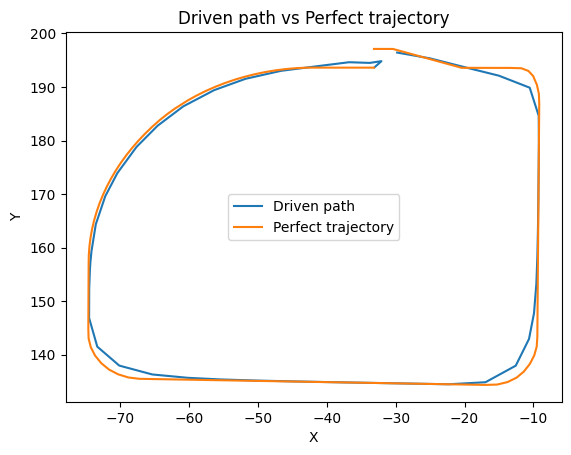

Average velocity: -0.01 m/s
Average acceleration: -0.07 m/s^2
Max acceleration: 2.35 m/s^2
Driven path length: 217.65 meters
Ideal trajectory length: 230.24 meters
DTW: 235.2662382848544
DTW: 235.2662382848544
Calculated score: 306.86
New calculated score: -67.95
There are 24 generated scenarios
13


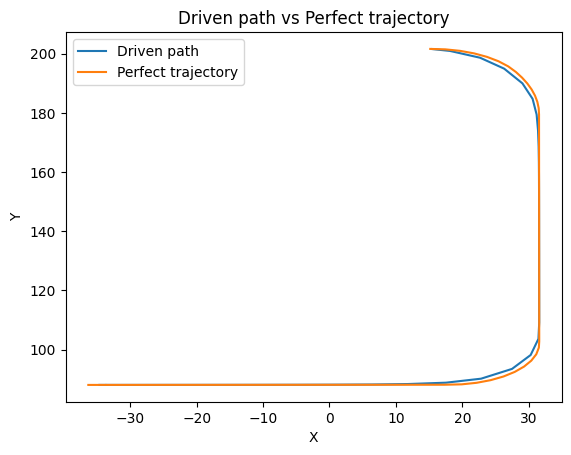

Average velocity: -0.60 m/s
Average acceleration: -0.05 m/s^2
Max acceleration: 2.20 m/s^2
Driven path length: 179.75 meters
Ideal trajectory length: 184.16 meters
DTW: 173.2935421343207
DTW: 173.2935421343207
Calculated score: 331.97
New calculated score: -69.21
There are 24 generated scenarios
15


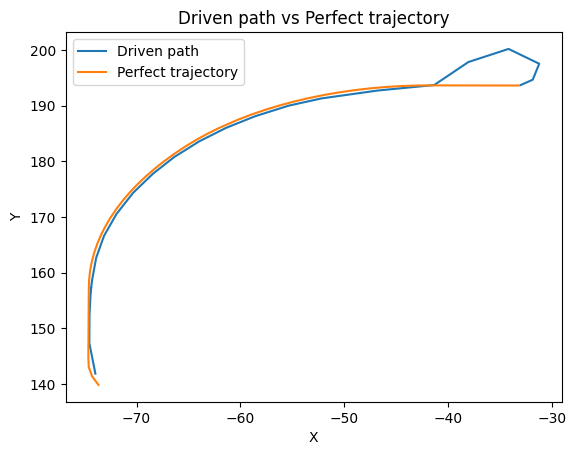

Average velocity: -0.97 m/s
Average acceleration: 0.01 m/s^2
Max acceleration: 0.91 m/s^2
Driven path length: 87.95 meters
Ideal trajectory length: 80.58 meters
DTW: 78.41254984265937
DTW: 78.41254984265937
Calculated score: 370.19
New calculated score: -31.53
There are 24 generated scenarios
16


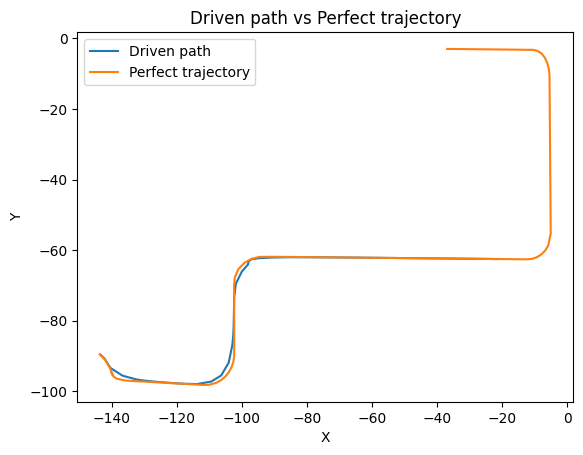

Average velocity: 1.90 m/s
Average acceleration: -0.01 m/s^2
Max acceleration: 1.87 m/s^2
Driven path length: 151.55 meters
Ideal trajectory length: 258.06 meters
DTW: 2320.5625636168006
DTW: 2320.5625636168006
Calculated score: 0.00
New calculated score: -931.18
There are 24 generated scenarios
10


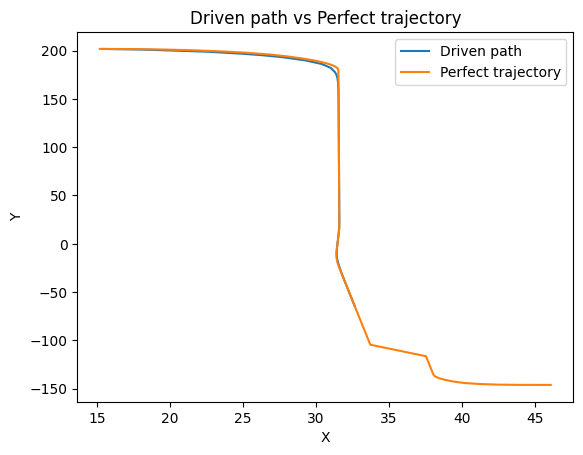

Average velocity: 0.10 m/s
Average acceleration: -0.00 m/s^2
Max acceleration: 1.84 m/s^2
Driven path length: 273.31 meters
Ideal trajectory length: 361.80 meters
DTW: 2222.2401418954155
DTW: 2222.2401418954155
Calculated score: 0.00
New calculated score: -891.82
There are 24 generated scenarios
1


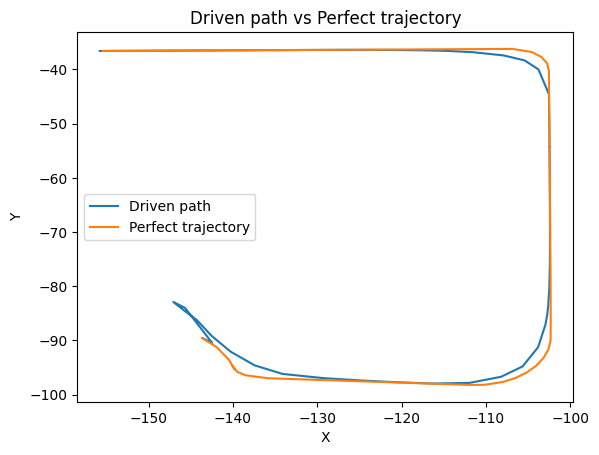

Average velocity: -0.24 m/s
Average acceleration: -0.12 m/s^2
Max acceleration: 1.82 m/s^2
Driven path length: 167.09 meters
Ideal trajectory length: 155.83 meters
DTW: 148.2738009226359
DTW: 148.2738009226359
Calculated score: 341.86
New calculated score: -57.39
There are 24 generated scenarios
22


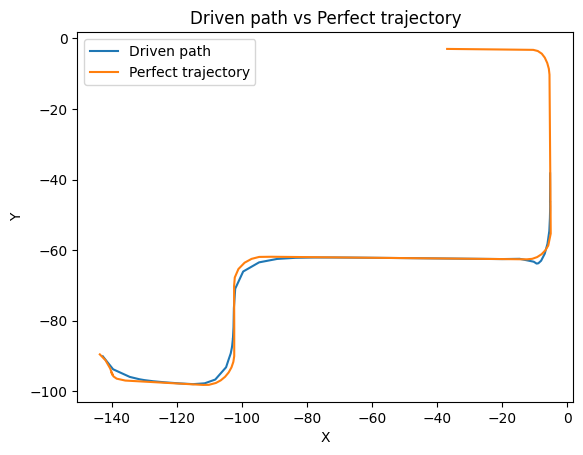

Average velocity: 1.99 m/s
Average acceleration: -0.03 m/s^2
Max acceleration: 2.17 m/s^2
Driven path length: 188.18 meters
Ideal trajectory length: 258.06 meters
DTW: 1190.4966023683703
DTW: 1190.4966023683703
Calculated score: 0.00
New calculated score: -477.75
There are 24 generated scenarios
3


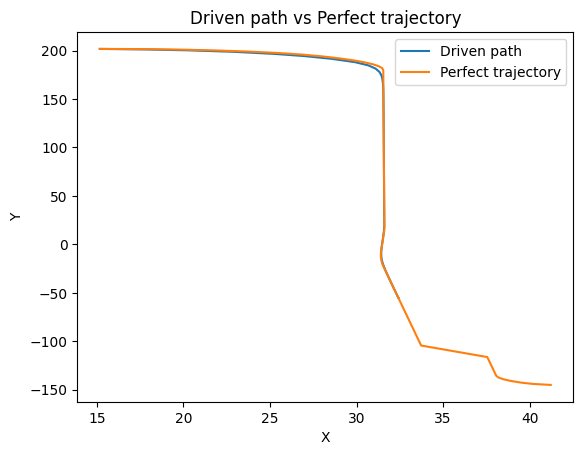

Average velocity: 0.09 m/s
Average acceleration: 0.00 m/s^2
Max acceleration: 1.13 m/s^2
Driven path length: 265.00 meters
Ideal trajectory length: 356.73 meters
DTW: 2217.096817250823
DTW: 2217.096817250823
Calculated score: 0.00
New calculated score: -889.64
There are 24 generated scenarios
5


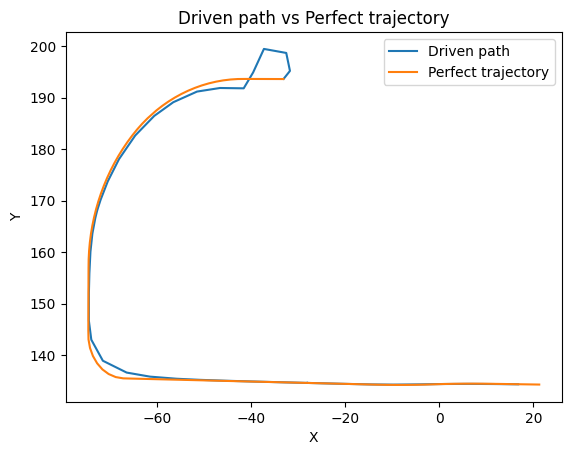

Average velocity: 0.54 m/s
Average acceleration: 0.06 m/s^2
Max acceleration: 2.17 m/s^2
Driven path length: 180.77 meters
Ideal trajectory length: 177.21 meters
DTW: 193.86103600463207
DTW: 193.86103600463207
Calculated score: 323.26
New calculated score: -77.33
There are 24 generated scenarios
12


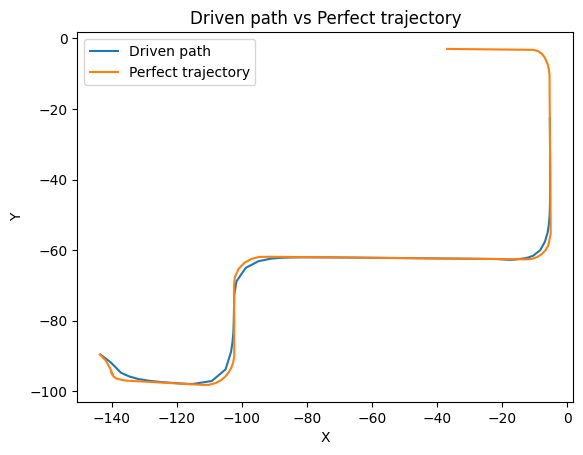

Average velocity: 0.77 m/s
Average acceleration: -0.01 m/s^2
Max acceleration: 2.71 m/s^2
Driven path length: 201.62 meters
Ideal trajectory length: 258.06 meters
DTW: 810.0579218568652
DTW: 810.0579218568652
Calculated score: 75.91
New calculated score: -325.10
There are 24 generated scenarios
14


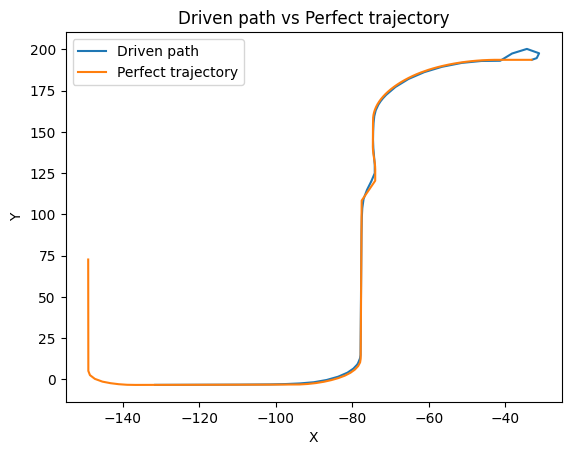

Average velocity: -0.57 m/s
Average acceleration: -0.02 m/s^2
Max acceleration: 1.74 m/s^2
Driven path length: 279.50 meters
Ideal trajectory length: 359.93 meters
DTW: 1986.151434987019
DTW: 1986.151434987019
Calculated score: 0.00
New calculated score: -796.85
There are 24 generated scenarios
20


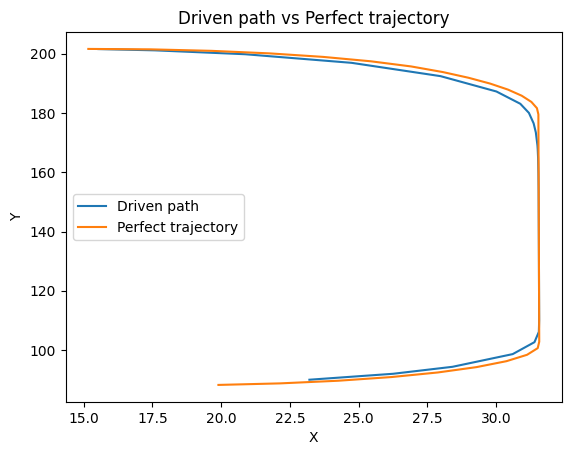

Average velocity: 0.04 m/s
Average acceleration: -0.03 m/s^2
Max acceleration: 1.53 m/s^2
Driven path length: 122.07 meters
Ideal trajectory length: 127.96 meters
DTW: 142.98736284133193
DTW: 142.98736284133193
Calculated score: 343.87
New calculated score: -60.83
There are 24 generated scenarios
17


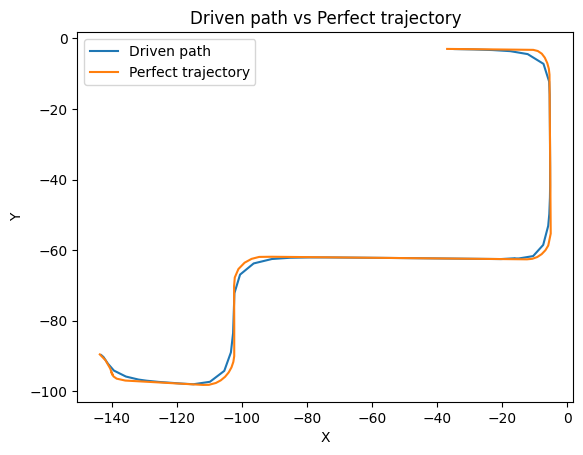

Average velocity: 0.79 m/s
Average acceleration: -0.03 m/s^2
Max acceleration: 2.78 m/s^2
Driven path length: 245.24 meters
Ideal trajectory length: 258.06 meters
DTW: 225.54483119430523
DTW: 225.54483119430523
Calculated score: 310.45
New calculated score: -90.67
There are 24 generated scenarios
7


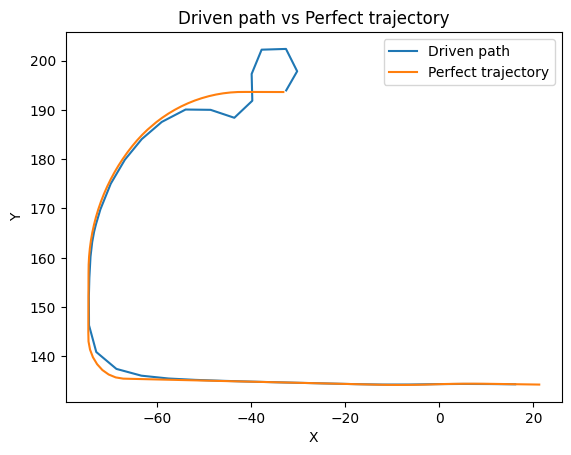

Average velocity: 0.51 m/s
Average acceleration: 0.02 m/s^2
Max acceleration: 2.66 m/s^2
Driven path length: 189.33 meters
Ideal trajectory length: 177.21 meters
DTW: 215.57754810352225
DTW: 215.57754810352225
Calculated score: 314.56
New calculated score: -86.34
There are 24 generated scenarios
19


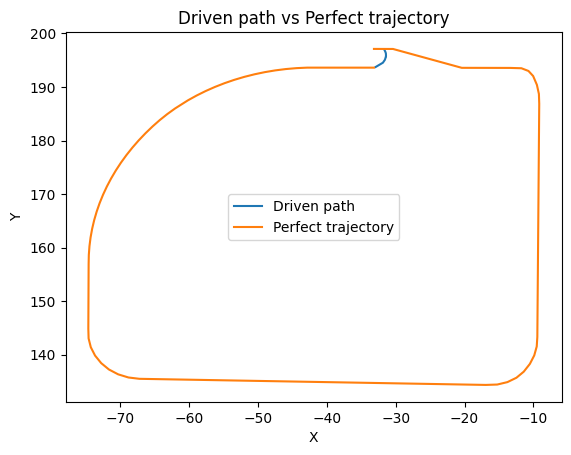

Average velocity: 0.03 m/s
Average acceleration: -0.06 m/s^2
Max acceleration: 0.00 m/s^2
Driven path length: 3.81 meters
Ideal trajectory length: 230.24 meters
DTW: 5471.360570892825
DTW: 5471.360570892825
Calculated score: 0.00
New calculated score: -2195.59
There are 24 generated scenarios
8


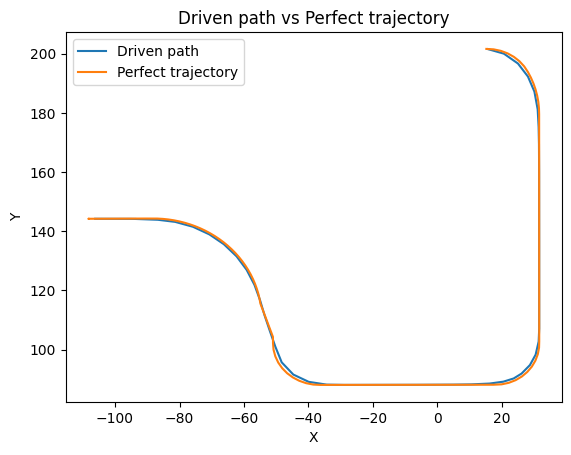

Average velocity: -0.86 m/s
Average acceleration: -0.04 m/s^2
Max acceleration: 2.53 m/s^2
Driven path length: 282.49 meters
Ideal trajectory length: 288.96 meters
DTW: 239.39649493522904
DTW: 239.39649493522904
Calculated score: 305.55
New calculated score: -95.86
There are 24 generated scenarios
2


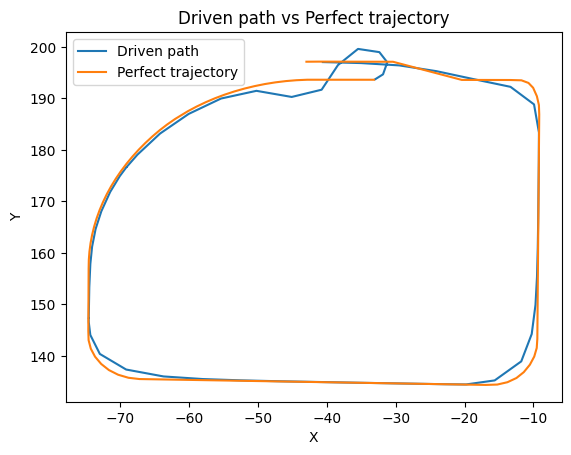

Average velocity: -0.07 m/s
Average acceleration: -0.04 m/s^2
Max acceleration: 2.25 m/s^2
Driven path length: 237.85 meters
Ideal trajectory length: 240.05 meters
DTW: 283.11750467195407
DTW: 283.11750467195407
Calculated score: 287.69
New calculated score: -111.61
There are 24 generated scenarios
18


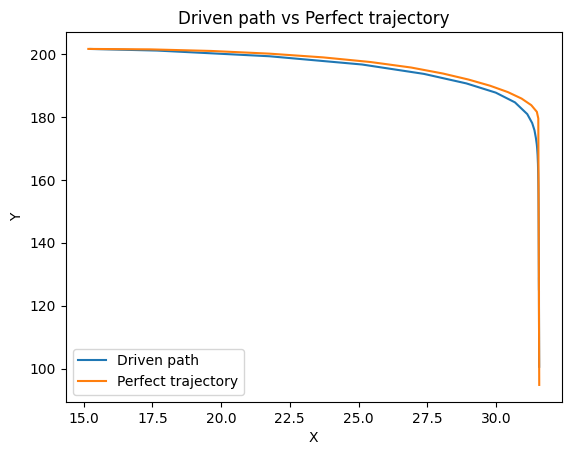

Average velocity: 0.19 m/s
Average acceleration: 0.01 m/s^2
Max acceleration: 2.39 m/s^2
Driven path length: 108.76 meters
Ideal trajectory length: 115.48 meters
DTW: 82.20652303932913
DTW: 82.20652303932913
Calculated score: 368.20
New calculated score: -32.89
There are 24 generated scenarios
0


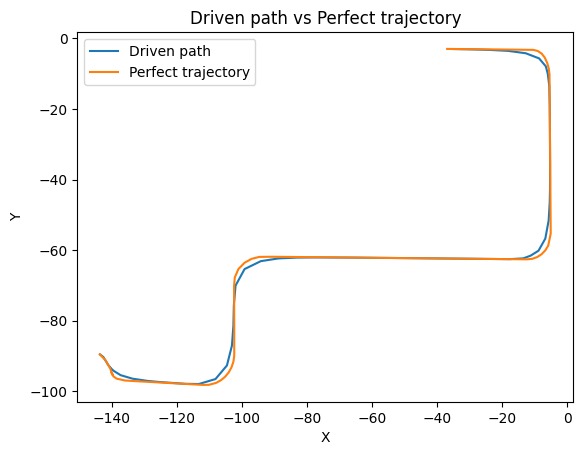

Average velocity: 0.77 m/s
Average acceleration: -0.04 m/s^2
Max acceleration: 2.12 m/s^2
Driven path length: 246.02 meters
Ideal trajectory length: 258.06 meters
DTW: 220.37875065677912
DTW: 220.37875065677912
Calculated score: 312.52
New calculated score: -88.64
There are 24 generated scenarios
11


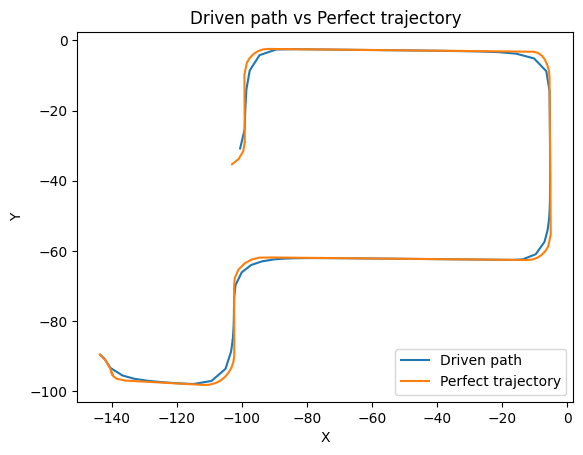

Average velocity: 0.29 m/s
Average acceleration: -0.03 m/s^2
Max acceleration: 1.96 m/s^2
Driven path length: 333.42 meters
Ideal trajectory length: 351.66 meters
DTW: 266.354769745896
DTW: 266.354769745896
Calculated score: 294.27
New calculated score: -107.29
There are 24 generated scenarios
6


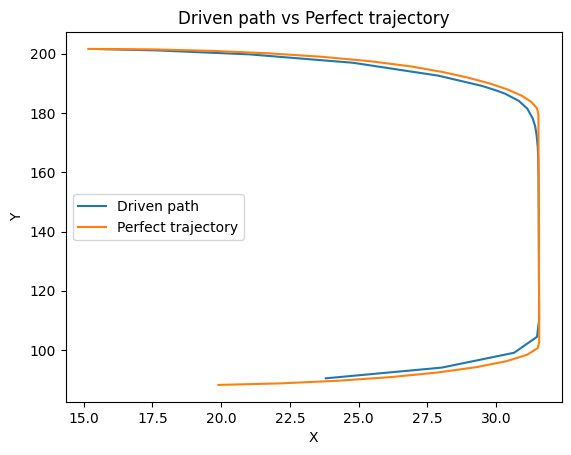

Average velocity: 0.04 m/s
Average acceleration: -0.04 m/s^2
Max acceleration: 1.49 m/s^2
Driven path length: 121.20 meters
Ideal trajectory length: 127.96 meters
DTW: 117.80483446254982
DTW: 117.80483446254982
Calculated score: 353.98
New calculated score: -51.39
There are 24 generated scenarios
4


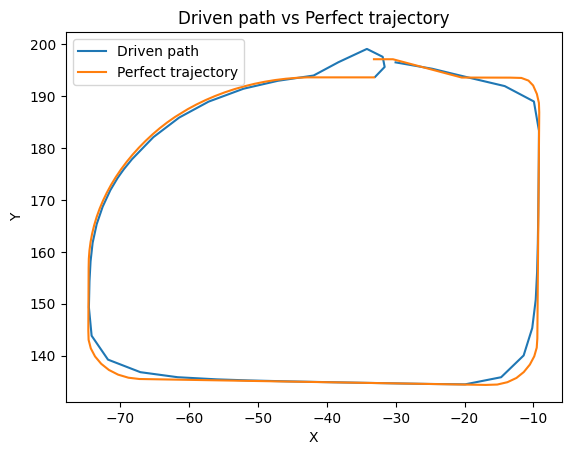

Average velocity: 0.00 m/s
Average acceleration: -0.07 m/s^2
Max acceleration: 1.97 m/s^2
Driven path length: 222.84 meters
Ideal trajectory length: 230.24 meters
DTW: 248.6611041689975
DTW: 248.6611041689975
Calculated score: 301.48
New calculated score: -340.75
There are 24 generated scenarios
9


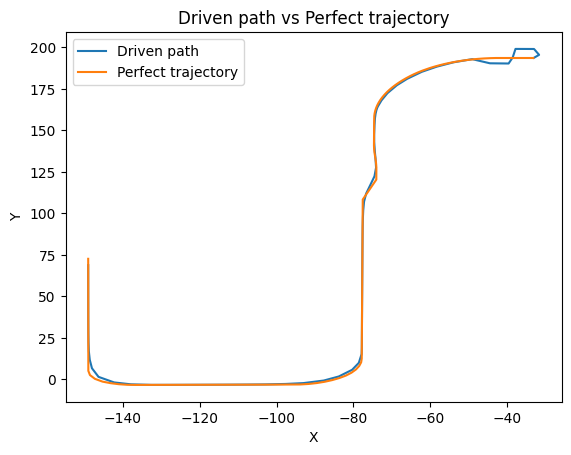

Average velocity: -1.01 m/s
Average acceleration: -0.01 m/s^2
Max acceleration: 2.63 m/s^2
Driven path length: 366.58 meters
Ideal trajectory length: 359.93 meters
DTW: 271.4468836623025
DTW: 271.4468836623025
Calculated score: 292.74
New calculated score: -108.87
There are 24 generated scenarios


In [2]:
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
from dtw import *
import math
import json
import matplotlib.pyplot as plt
import numpy as np
import os

rated_objects = []
count = 0
for root, dirs, files in os.walk('user_input/NN_run/step2'):
    for file in files:
        if 'auto_scenario' in file:
        
            
            # Extract the number from the file name
            scenario_num = int(file.split('_')[-1].split('.')[0])
            print(scenario_num)
            # Open the corresponding route file
            with open(f'user_input/NN_run/step1/random_route_{scenario_num}.json', 'r') as f:
                trajectory = json.load(f)

            with open(f'user_input/NN_run/step2/auto_scenario_{scenario_num}.json') as f:
                driven_path_data = json.load(f)


            def get_trajectory_length(trajectory):
                # Extract the X and Y coordinates from each location
                x_coords = [location['X'] for location in trajectory]
                y_coords = [location['Y'] for location in trajectory]

                # Compute the Euclidean distances between consecutive points
                distances = [math.sqrt((x2 - x1)**2 + (y2 - y1)**2) for x1, y1, x2, y2 in zip(x_coords[:-1], y_coords[:-1], x_coords[1:], y_coords[1:])]

                # Return the total length of the trajectory
                return sum(distances)

            def path_length(path):
                length = 0
                for i in range(1, len(path)):
                    x1, y1 = path[i-1]
                    x2, y2 = path[i]
                    segment_length = math.sqrt((x2-x1)**2 + (y2-y1)**2)
                    length += segment_length
                return length

    
            driven_path = [(d['vehicle_location']['x'], d['vehicle_location']['y']) for d in driven_path_data]
            
            # Plot the driven path
            plt.plot(*zip(*driven_path), label='Driven path')

            # Extract the X and Y coordinates from each location
            x_coords = [location['X'] for location in trajectory]
            y_coords = [location['Y'] for location in trajectory]

            # Plot the route on a graph
            plt.plot(x_coords, y_coords, label='Perfect trajectory')

            plt.title('Driven path vs Perfect trajectory')
            plt.xlabel('X')
            plt.ylabel('Y')
            plt.legend()
            plt.show()

            # Initialize lists to store data
            timestamps = []
            velocities = []
            throttles = []

            # Extract values from data
            game_time = [entry['game_time'] for entry in driven_path_data]
            velocity = [entry['vehicle_velocity']['x'] for entry in driven_path_data]
            throttle = [entry['vehicle_throttle'] for entry in driven_path_data]

            # Calculate average velocity
            avg_velocity = np.mean(velocity)
            print(f'Average velocity: {avg_velocity:.2f} m/s')

            # Calculate acceleration
            dt = np.mean(np.diff(game_time))
            acceleration = np.gradient(velocity, dt)
            avg_acceleration = np.mean(acceleration)
            print(f'Average acceleration: {avg_acceleration:.2f} m/s^2')
            max_acceleration = max(acceleration)
            print(f'Max acceleration: {max_acceleration:.2f} m/s^2')

            driven_path_length = path_length(driven_path)
            print(f"Driven path length: {driven_path_length:.2f} meters")
            
            ideal_trajectory_length = get_trajectory_length(trajectory)
            print(f"Ideal trajectory length: {ideal_trajectory_length:.2f} meters")

            def new_rate_driven_path(trajectory, driven_path, avg_velocity, avg_acceleration, num_collisions):
                # Calculate the DTW distance between the trajectory and driven path
                distance, _ = fastdtw(trajectory, driven_path, dist=euclidean)

                print("DTW: "+str(distance))

                # Calculate the safety score based on distance, velocity, and acceleration
                velocity_factor = 0.01  # Weighting factor for velocity
                acceleration_factor = 0.001  # Weighting factor for acceleration
                length_factor = driven_path_length / ideal_trajectory_length  # Scaling factor based on length ratio
                scaling_factor = (1000 / avg_velocity) * (avg_acceleration / 100)  # Scaling factor based on velocity and acceleration
                safety_score = scaling_factor * length_factor - distance - velocity_factor * avg_velocity - acceleration_factor * avg_acceleration

                # Penalize for number of collisions
                safety_score -= safety_score * (0.95**num_collisions)

                return safety_score

            def rate_driven_path(trajectory, driven_path, avg_velocity, num_collisions):
                # Calculate the DTW distance between the trajectory and driven path
                distance, _ = fastdtw(trajectory, driven_path, dist=euclidean)
                
                print("DTW: "+str(distance))
                # Calculate the safety score based on DTW distance and average velocity
                safety_score = max(0, 1000 - distance - avg_velocity)
                
                # Penalize for number of collisions
                safety_score -= safety_score * (0.95**num_collisions)
            
                return safety_score

            # # # Plot velocity over time
            # plt.plot(game_time, velocity)
            # plt.xlabel('Time (s)')
            # plt.ylabel('Velocity (m/s)')
            # plt.show()

            # # Plot acceleration over time
            # plt.plot(game_time, acceleration)
            # plt.xlabel('Time (s)')
            # plt.ylabel('Acceleration (m/s^2)')
            # plt.show()

            perfect_trajectory_array = list(zip(x_coords, y_coords))
            driven_path_array = np.array(driven_path)

            calculated_score = rate_driven_path(perfect_trajectory_array, driven_path_array,avg_velocity,10)
            new_calculated_score = new_rate_driven_path(perfect_trajectory_array, driven_path_array,avg_velocity,avg_acceleration,10)
            print(f'Calculated score: {calculated_score:.2f}')
            print(f'New calculated score: {new_calculated_score:.2f}')
            # Open the file for reading
            with open('user_input/NN_run/step1/random_scenarios.json', 'r') as f:
                data = json.load(f)

            print(f'There are {len(data)} generated scenarios')
            
           
            # Find the object with the desired scenario_num
            for obj in data:
                if obj['scenario_num'] == scenario_num:
                    # Add the new variable
                    obj['calculate_score'] = calculated_score  # Replace 0 with your desired value
                    rated_objects.append(obj)

# Open the file for writing
with open('user_input/NN_run/step3/rated_scenarios.json', 'w') as f:
    json.dump(rated_objects, f,indent=4)

Step 4: Train NN MLP on rated scenarios

In [3]:
import json
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.neural_network import MLPRegressor

# Load data from JSON file
with open('user_input/NN_run/step3/rated_scenarios.json', 'r') as f:
    data = json.load(f)

# Extract features and target variable
X = []
y = []
for obj in data:
    X.append([
        obj['weather'],
        obj['vehicle'],
        obj['traffic'],
        obj['emergency'],
        obj['timeOfDay'],
        obj['location'],
        obj['intersections'],
        int(obj['pedestrians']),
        int(obj['pedestrian_cross']),
        obj['rounded_route_length'],
        
    ])
    y.append(obj['calculate_score'])
X = np.array(X)
y = np.array(y)

# Encode categorical features
categorical_features = [0, 1, 2, 3, 4, 5]
encoders = []
for i in categorical_features:
    le = LabelEncoder()
    ohe = OneHotEncoder(sparse=False)
    X[:, i] = le.fit_transform(X[:, i])
    encoders.append((le, ohe))
X = ohe.fit_transform(X)

# Split data into training and test sets
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Train neural network regressor
nn = MLPRegressor(hidden_layer_sizes=(100,), max_iter=100000)
nn.fit(X_train, y_train)

# Make predictions on test set
y_pred = nn.predict(X_test)

# Evaluate model performance (e.g. using mean squared error)
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
print(f'MSE: {mse:.2f}')


MSE: 47083.30


Step 5: Generate new random scenarios 

In [4]:
import json
import random
from agents.navigation.global_route_planner import GlobalRoutePlanner
import carla
class ScenarioGenerator:
    def __init__(self, weather, vehicle, traffic, emergency, timeOfDay, location, intersections, pedestrians, pedestrian_cross,route_length, num_scenarios):
        self.weather = weather
        self.vehicle = vehicle
        self.traffic = traffic
        self.emergency = emergency
        self.timeOfDay = timeOfDay
        self.location = location
        self.intersections = intersections
        self.pedestrians = pedestrians
        self.pedestrian_cross = pedestrian_cross
        self.num_scenarios = num_scenarios
        self.route_length = route_length
        
    def generate_scenarios(self):
        

         # Create dictionaries that map each variable value to a difficulty rating
        weather_difficulty = {'Sunny': 1, 'Rain': 5, 'Thunderstorm': 8}
        vehicle_difficulty = {'Small': 1, 'Truck': 2,'Van': 3}
        traffic_difficulty = {'Heavy': 6, 'Light': 1,'Medium': 3}
        emergency_difficulty = {'Yes': 10, 'No': 0}
        timeOfDay_difficulty = {'Day': 1, 'Night':5,'Dawn':2,'Dusk':2}
        location_difficulty = {'Urban':4 , 'Country' :1 ,'Downtown' :3 }
        intersections_difficulty = {0:1 ,1:2 ,2:3 ,3:4 ,4:5 ,5:6 }
        pedestrians_difficulty = {True: 0.5 ,False : 0}
        pedestrian_cross_difficulty = {True : 10, False : 0 }
        route_length_difficulty ={50 :0.5 ,100 :1.5,200 : 2 ,250:2.5,300:3,400:4,500:5,600:6}

        generated_scenarios = []
        for i in range(self.num_scenarios):
            # Randomly choose values for each variable
            weather_choice = random.choice(self.weather)
            vehicle_choice = random.choice(self.vehicle)
            traffic_choice = random.choice(self.traffic)
            emergency_choice= random.choice(self.emergency)
            timeOfDay_choice= random.choice(self.timeOfDay)
            location_choice= random.choice(self.location)
            intersections_choice= random.choice(self.intersections)
            pedestrians_choice= random.choice(self.pedestrians)
            pedestrian_cross_choice= random.choice(self.pedestrian_cross)
            route_length_choice=random.choice(self.route_length)

            
            client = carla.Client("localhost", 2000)
            
            if location_choice == "Downtown":
                world = client.load_world('Town05')
            if location_choice == "Urban":
                world = client.load_world('Town03')
            if location_choice == "Country":
                world = client.load_world('Town07')
            
            map = world.get_map()
            grp = GlobalRoutePlanner(map,2)

          
            waypoints = map.generate_waypoints(2.0)


            def get_route_length(route):
                length = 0
                for i in range(len(route) - 1):
                    length += route[i][0].transform.location.distance(route[i + 1][0].transform.location)
                return length
            
            start_waypoint = 0
            end_waypoint = 0
            for start_waypoint in waypoints:
                for end_waypoint in waypoints:
                    # print(start_waypoint.transform.location.distance(end_waypoint.transform.location))
                    route = grp.trace_route(start_waypoint.transform.location, end_waypoint.transform.location)
                    found_route_length = get_route_length(route)
                
                    
                    # Get unique road IDs
                    road_ids = list(set(waypoint[0].road_id for waypoint in route))
                    junction_road_ids = []
                    junctions_on_route = 0
                    if intersections_choice > 0:
                        for road_id in road_ids:
                            # waypoints = map.generate_waypoints(2.0)
                            for waypoint in route:
                                if waypoint[0].road_id == road_id and waypoint[0].is_junction:
                                    junction_road_ids.append(road_id)
                                    # draw_waypoints(waypoints, road_id=road_id, life_time=300)
                        junctions_on_route = len(list(set(junction_road_ids)))

                    if (found_route_length > (route_length_choice-(route_length_choice*0.2)) 
                        and found_route_length < (route_length_choice+(route_length_choice*0.2))
                        and junctions_on_route >= intersections_choice):
                        # print("wassup")
                        found = True
                        start_waypoint = start_waypoint.transform.location
                        end_waypoint = end_waypoint.transform.location

                        # Get unique road IDs
                        road_ids = list(set(waypoint[0].road_id for waypoint in route))

                        junction_road_ids = []
                        junctions_on_route = 0
                        for road_id in road_ids:
                            # waypoints = map.generate_waypoints(2.0)
                            for waypoint in route:
                                if waypoint[0].road_id == road_id and waypoint[0].is_junction:
                                    junction_road_ids.append(road_id)
                    
                        junctions_on_route = len(list(set(junction_road_ids)))
                        
                        # print(f"Need intersections: {intersections_choice}")
                        # print(f"Result intersections: {junctions_on_route}")
                        # # print(f"Unique road IDs along the route: {road_ids}")
                        # print(f"Euclidean Distance between: {start_waypoint.distance(end_waypoint)}")
                        # print(f"Need to find length: {route_length_choice}")
                        # print(f"Found Route length: {found_route_length}")


                        total_difficulty_rating = (weather_difficulty[weather_choice] +
                            vehicle_difficulty[vehicle_choice] +
                            traffic_difficulty[traffic_choice] +
                            emergency_difficulty[emergency_choice] +
                            timeOfDay_difficulty[timeOfDay_choice] +
                            location_difficulty[location_choice]+
                            (junctions_on_route*5)+
                            pedestrians_difficulty[pedestrians_choice]+
                            pedestrian_cross_difficulty[pedestrian_cross_choice]+
                                    found_route_length)
                        
                        # Create a scenario dictionary with the chosen variable values and total difficulty rating
                        scenario = {
                            'scenario_num': i,
                            'weather': weather_choice,
                            'vehicle': vehicle_choice,
                            'traffic': traffic_choice,
                            'emergency': emergency_choice,
                            'timeOfDay': timeOfDay_choice,
                            'location': location_choice,
                            "intersections": junctions_on_route,
                            "pedestrians": pedestrians_choice,
                            "pedestrian_cross": pedestrian_cross_choice,
                            "start_x": start_waypoint.x,
                            "start_y": start_waypoint.y,
                            "end_x": end_waypoint.x,
                            "end_y": end_waypoint.y,
                            "rounded_route_length": route_length_choice,
                            "route_length": found_route_length,
                            "total_difficulty_rating": total_difficulty_rating
                        }

                        print(scenario)

                        # Create a list of dictionaries representing each location in the route
                        locations = []
                        for waypoint, _ in route:
                            location = waypoint.transform.location
                            locations.append({'X': location.x, 'Y': location.y})

                        # Save the locations to a JSON file
                        with open(f'user_input/NN_run/step5/random_route_{i}.json', 'w') as f:
                            json.dump(locations, f,indent=4)

                        generated_scenarios.append(scenario)
                        break
                        # build path using the route
                if found:
                    break
        
        # print(len(generated_scenarios))
        with open('user_input/NN_run/step5/random_scenarios.json', 'w') as f:
            json.dump(generated_scenarios, f, indent=4)
        
        return generated_scenarios

weather = ['Sunny', 'Rain', 'Thunderstorm']
vehicle = ['Small', 'Truck','Van']
traffic = ['Heavy', 'Light','Medium']
emergency = ['Yes', 'No']
timeOfDay = ['Day', 'Night','Dawn','Dusk']
location = ['Urban', 'Country','Downtown']
intersections = [0,1,2,3,4]
pedestrians = [True,False]
pedestrian_cross = [True, False]
route_length = [100,150,200,250,300,350,400]
num_scenarios = 10


scenario_generator = ScenarioGenerator(weather, vehicle, traffic, emergency, timeOfDay, location, intersections, pedestrians, pedestrian_cross,route_length, num_scenarios)
random_scenarios = scenario_generator.generate_scenarios()

{'scenario_num': 0, 'weather': 'Thunderstorm', 'vehicle': 'Van', 'traffic': 'Heavy', 'emergency': 'Yes', 'timeOfDay': 'Day', 'location': 'Downtown', 'intersections': 9, 'pedestrians': True, 'pedestrian_cross': False, 'start_x': 15.171202659606934, 'start_y': 201.64096069335938, 'end_x': 46.10598373413086, 'end_y': -146.00099182128906, 'rounded_route_length': 400, 'route_length': 361.8046474456787, 'total_difficulty_rating': 438.3046474456787}
{'scenario_num': 1, 'weather': 'Thunderstorm', 'vehicle': 'Van', 'traffic': 'Heavy', 'emergency': 'Yes', 'timeOfDay': 'Day', 'location': 'Urban', 'intersections': 8, 'pedestrians': True, 'pedestrian_cross': True, 'start_x': -33.171356201171875, 'start_y': 193.61383056640625, 'end_x': -33.16262435913086, 'end_y': 197.1138153076172, 'rounded_route_length': 200, 'route_length': 230.24243074655533, 'total_difficulty_rating': 312.7424307465553}
{'scenario_num': 2, 'weather': 'Sunny', 'vehicle': 'Small', 'traffic': 'Heavy', 'emergency': 'Yes', 'timeOfDa

Step 6: Predict the actor safety score in these scenarios and filter out easy scenarios

In [5]:
import numpy as np
# Load data from JSON file
with open('user_input/NN_run/step5/random_scenarios.json', 'r') as f:
    data = json.load(f)

# Extract features
X_unrated = []
for obj in data:
    X_unrated.append([
        obj['weather'],
        obj['vehicle'],
        obj['traffic'],
        obj['emergency'],
        obj['timeOfDay'],
        obj['location'],
        obj['intersections'],
        int(obj['pedestrians']),
        int(obj['pedestrian_cross']),
        obj['rounded_route_length']
    ])

X_unrated = np.array(X_unrated)

# Encode categorical features
for i in categorical_features:
    le, ohe = encoders[i]
    X_unrated[:, i] = le.transform(X_unrated[:, i])
X_unrated = ohe.transform(X_unrated)

# Make predictions on unrated scenarios
y_pred_unrated = nn.predict(X_unrated)


# Create a new list to store scenarios with predicted score >= 500
high_score_scenarios = []
rejected_scenarios = []

for obj, pred in zip(data, y_pred_unrated):
    print(f"W: {obj['weather']}, V: {obj['vehicle']}, T: {obj['traffic']}, E: {obj['emergency']}, TD: {obj['timeOfDay']}, L: {obj['location']}, I: {obj['intersections']}, P: {int(obj['pedestrians'])}, PC: {int(obj['pedestrian_cross'])}, RL: {obj['route_length']}")
    print(f"Predicted Score: {pred:.2f}")
    print()
    obj['predicted_score'] = pred
    if pred <= 500:
        high_score_scenarios.append(obj)

# Write updated data to JSON file
with open('user_input/NN_run/step6/high_score_scenarios.json', 'w') as f:
    json.dump(high_score_scenarios, f, indent=4) 





W: Thunderstorm, V: Van, T: Heavy, E: Yes, TD: Day, L: Downtown, I: 9, P: 1, PC: 0, RL: 361.8046474456787
Predicted Score: -58.10

W: Thunderstorm, V: Van, T: Heavy, E: Yes, TD: Day, L: Urban, I: 8, P: 1, PC: 1, RL: 230.24243074655533
Predicted Score: 203.59

W: Sunny, V: Small, T: Heavy, E: Yes, TD: Night, L: Urban, I: 3, P: 1, PC: 0, RL: 80.5826963186264
Predicted Score: 339.88

W: Rain, V: Truck, T: Medium, E: No, TD: Night, L: Urban, I: 8, P: 0, PC: 0, RL: 230.24243074655533
Predicted Score: 252.31

W: Thunderstorm, V: Truck, T: Heavy, E: No, TD: Dawn, L: Country, I: 10, P: 0, PC: 1, RL: 258.05940064787865
Predicted Score: 67.14

W: Rain, V: Truck, T: Medium, E: No, TD: Night, L: Urban, I: 8, P: 1, PC: 0, RL: 230.24243074655533
Predicted Score: 271.83

W: Sunny, V: Small, T: Medium, E: Yes, TD: Day, L: Downtown, I: 4, P: 1, PC: 0, RL: 115.47674536705017
Predicted Score: 320.86

W: Sunny, V: Truck, T: Light, E: No, TD: Dawn, L: Urban, I: 6, P: 0, PC: 0, RL: 359.94037771224976
Predic

Step 7: Run the filtered scenarios 

In [6]:
import carla
import json
import os
import time 
from agents.navigation.global_route_planner import GlobalRoutePlanner
import random
import math
from agents.navigation.basic_agent import BasicAgent
from carla import WeatherParameters
import logging
from carla import VehicleLightState as vls

 # Open the JSON file
with open("user_input/NN_run/step6/high_score_scenarios.json", "r") as file:
    scenario_data = json.load(file)

# Initialize variables with the values from the JSON file


def main():
    
    for scenario_num in range(len(scenario_data)):
        try:

            scenario_number = scenario_data[scenario_num]["scenario_num"]
            weather = scenario_data[scenario_num]["weather"]
            intersections = scenario_data[scenario_num]["intersections"]
            vehicle = scenario_data[scenario_num]["vehicle"]
            traffic = scenario_data[scenario_num]["traffic"]
            emergency = scenario_data[scenario_num]["emergency"]
            timeOfDay = scenario_data[scenario_num]["timeOfDay"]
            location = scenario_data[scenario_num]["location"]
            pedestrians = scenario_data[scenario_num]["pedestrians"]
            pedestrian_cross = scenario_data[scenario_num]["pedestrian_cross"]
            start_x = scenario_data[scenario_num]["start_x"]
            start_y = scenario_data[scenario_num]["start_y"]
            end_x = scenario_data[scenario_num]["end_x"]
            end_y = scenario_data[scenario_num]["end_y"]
            route_length = scenario_data[scenario_num]["route_length"]
            total_difficulty_rating = scenario_data[scenario_num]["total_difficulty_rating"]

            client = carla.Client("localhost", 2000)

            if location == "Downtown":
                world = client.load_world('Town05')
            if location == "Urban":
                world = client.load_world('Town03')
            if location == "Country":
                world = client.load_world('Town07')

            spectator = world.get_spectator()
            map = world.get_map()

            traffic_manager = client.get_trafficmanager(8000)
            traffic_manager.set_global_distance_to_leading_vehicle(2.5)
            traffic_manager.set_synchronous_mode(True)
            traffic_manager.global_percentage_speed_difference(50.0)


            cloudiness=0.0,
            precipitation=0.0,
            sun_altitude_angle=70.0  # 70 degrees is around noon

            # Set the weather conditions
            if weather == "Sunny":
                cloudiness=10
                precipitation=0.0
                precipitation_deposits=0

            elif weather == "Rain":
                cloudiness=80
                precipitation=60.0
                precipitation_deposits=30
                
            elif weather == "Thunderstorm":
                cloudiness=100
                precipitation=90.0
                precipitation_deposits=60
                

            if timeOfDay == "Day":
                sun_altitude_angle=70.0
            elif timeOfDay == "Night":
                sun_altitude_angle=-30.0
            elif timeOfDay == "Dawn":
                sun_altitude_angle=20.0
            elif timeOfDay == "Dusk":
                sun_altitude_angle=110.0

            weather_params = WeatherParameters(
                cloudiness=cloudiness,
                precipitation=precipitation,
                sun_altitude_angle=sun_altitude_angle,  
                precipitation_deposits=precipitation_deposits 
            )

            # Set the weather in the simulation
            world.set_weather(weather_params)

    
            grp = GlobalRoutePlanner(map,2)

            spawn_points = map.get_spawn_points()

            # Set the desired number of junctions
            num_junctions = intersections

            waypoints = map.generate_waypoints(2.0)

            def draw_waypoints(waypoints, road_id=None, life_time=50.0):
                spawned = False 
                for waypoint in waypoints:
                    
                    if(waypoint.road_id == road_id):
                        world.debug.draw_string(waypoint.transform.location, "JUNC", draw_shadow=False,
                                                color=carla.Color(r=0, g=255, b=0), life_time=life_time,
                                                persistent_lines=True)

            def get_route_length(route):
                length = 0
                for i in range(len(route) - 1):
                    length += route[i][0].transform.location.distance(route[i + 1][0].transform.location)
                return length
            
            start_location = carla.Location(x=start_x,y=start_y)
            end_location = carla.Location(x=end_x,y=end_y)
            
            # print(start_waypoint.transform.location.distance(end_waypoint.transform.location))
            route = grp.trace_route(start_location,end_location)
        
                    
            # The 'waypoints' variable now contains a list of waypoints that define a route between 'start_pose' and 'end_pose' that goes through 'num_junctions' junctions.

            i = 0
            for w in route:
                if i % 10 == 0:
                    world.debug.draw_string(w[0].transform.location, 'O', draw_shadow=False,
                    color=carla.Color(r=255, g=0, b=0), life_time=1000.0,
                    persistent_lines=True)
                else:
                    world.debug.draw_string(w[0].transform.location, 'O', draw_shadow=False,
                    color = carla.Color(r=0, g=0, b=255), life_time=1000.0,
                    persistent_lines=True)
                i += 1

            vehicles_list = []
            walkers_list = []
            all_id = []

            def spawn_random_pedestrians_and_cars(world, route):
                # Get the blueprint library
                blueprint_library = world.get_blueprint_library()

                # Get the pedestrian and car blueprints
                pedestrian_blueprints = blueprint_library.filter("walker.pedestrian.*")
                car_blueprints = blueprint_library.filter("vehicle.*")

                # Set the number of pedestrians and cars to spawn
                num_pedestrians = 0
                num_cars = 10

                # Spawn pedestrians along the route
                for i in range(num_pedestrians):
                    # Choose a random waypoint along the route
                    waypoint = random.choice(route)[0]

                    # Choose a random pedestrian blueprint
                    pedestrian_bp = random.choice(pedestrian_blueprints)

                    # Spawn the pedestrian at the waypoint location
                    world.try_spawn_actor(pedestrian_bp, waypoint.transform)

                # Spawn cars along the route
                for i in range(num_cars):
                    # Choose a random waypoint along the route
                    waypoint = random.choice(route)[0]

                    # Choose a random car blueprint
                    car_bp = random.choice(car_blueprints)

                    

                    # Spawn the car at the waypoint location with some offset in z-axis to prevent collision with ground.
                    transform = carla.Transform(waypoint.transform.location + carla.Location(z=0.5),waypoint.transform.rotation)
                    
                    vehicle_actor = world.try_spawn_actor(car_bp, transform)
                    
                    if vehicle_actor:
                        # Set the vehicle to autopilot
                        vehicles_list.append(vehicle_actor)
                        vehicle_actor.set_autopilot(True)

            def get_first_last_location(route):
                first_location = route[0][0].transform.location
                last_location = route[-1][0].transform.location
                return first_location, last_location

            
            first_location, last_location = get_first_last_location(route)

            # Spawn a vehicle and set it to drive to destination
            blueprint_library = world.get_blueprint_library()
            pedestrian_bps = blueprint_library.filter("walker.pedestrian.*")

            if vehicle == "Small":
                vehicle_bp = blueprint_library.filter("a2")[0]
            elif vehicle == "Truck":
                vehicle_bp = blueprint_library.filter("cybertruck")[0]
            elif vehicle == "Van":
                vehicle_bp = blueprint_library.filter("carlacola")[0]
                 
            vehicle_actor = world.spawn_actor(vehicle_bp, carla.Transform(first_location+carla.Location(z=0.5)))
            
            vehicles_list.append(vehicle_actor)

            vehicle_ids = []
            if traffic == "Light" or traffic == "Heavy" or traffic == "Medium": 
                
                filtered_spawn_points = []

                # Get unique road IDs
                road_ids = list(set(waypoint[0].road_id for waypoint in route))
              
                for road_id in road_ids:
                    # waypoints = map.generate_waypoints(2.0)
                    for point in spawn_points:
                        if map.get_waypoint(point.location).road_id == road_id:
                            filtered_spawn_points.append(point)
                       
                number_of_spawn_points = len(filtered_spawn_points)

                if traffic == "Light":
                    num_cars = 15
                elif traffic == "Medium":
                    num_cars = 25
                elif traffic == "Heavy":
                    num_cars = 40
                
                SpawnActor = carla.command.SpawnActor
                SetAutopilot = carla.command.SetAutopilot
                SetVehicleLightState = carla.command.SetVehicleLightState
                FutureActor = carla.command.FutureActor

                blueprints = world.get_blueprint_library().filter('vehicle.*')
                blueprints = sorted(blueprints, key=lambda bp: bp.id)

                if num_cars < number_of_spawn_points:
                    random.shuffle(filtered_spawn_points)
                elif num_cars > number_of_spawn_points:
                    msg = 'requested %d vehicles, but could only find %d spawn points'
                    logging.warning(msg, num_cars, number_of_spawn_points)
                    num_cars = number_of_spawn_points


                batch = []
                for n, transform in enumerate(filtered_spawn_points):
                    # print(transform)
                    if n >= num_cars:
                        break
                    blueprint = random.choice(blueprints) 
                    if blueprint.has_attribute('color'):
                        color = random.choice(blueprint.get_attribute('color').recommended_values)
                        blueprint.set_attribute('color', color)
                    if blueprint.has_attribute('driver_id'):
                        driver_id = random.choice(blueprint.get_attribute('driver_id').recommended_values)
                        blueprint.set_attribute('driver_id', driver_id)

                
                    blueprint.set_attribute('role_name', 'autopilot')

                    # prepare the light state of the cars to spawn
                    light_state = vls.NONE
                    if True:
                        light_state = vls.Position | vls.LowBeam | vls.LowBeam

                    # spawn the cars and set their autopilot and light state all together
                    batch.append(SpawnActor(blueprint, transform)
                        .then(SetAutopilot(FutureActor, True, traffic_manager.get_port()))
                        .then(SetVehicleLightState(FutureActor, light_state)))

                spawn_random_pedestrians_and_cars(world,route)  
                    
                for response in client.apply_batch_sync(batch, True):
                    if response.error:
                        logging.error(response.error)
                    else:
                        vehicle_ids.append(response.actor_id)

            if pedestrians == True:
                if emergency == "No":
                    percentagePedestriansRunning = 20     # how many pedestrians will run
                    percentagePedestriansCrossing = 30     # how many pedestrians will walk through the road
                else:
                    percentagePedestriansRunning = 80
                    percentagePedestriansCrossing = 70
                
                # 1. take all the random locations to spawn
                spawn_points = []
                for i in range(30):
                    spawn_point = carla.Transform()
                    loc = world.get_random_location_from_navigation()
                    if (loc != None):
                        spawn_point.location = loc
                        spawn_points.append(spawn_point)
                # 2. we spawn the walker object
                batch = []
                walker_speed = []
                for spawn_point in spawn_points:
                    walker_bp = random.choice(pedestrian_bps)
                    # set as not invincible
                    if walker_bp.has_attribute('is_invincible'):
                        walker_bp.set_attribute('is_invincible', 'false')
                    # set the max speed
                    if walker_bp.has_attribute('speed'):
                        if (random.random() > percentagePedestriansRunning):
                            # walking
                            walker_speed.append(walker_bp.get_attribute('speed').recommended_values[1])
                        else:
                            # running
                            walker_speed.append(walker_bp.get_attribute('speed').recommended_values[2])
                    else:
                        print("Walker has no speed")
                        walker_speed.append(0.0)
                    batch.append(SpawnActor(walker_bp, spawn_point))
                results = client.apply_batch_sync(batch, True)
                walker_speed2 = []
                for i in range(len(results)):
                    if results[i].error:
                        logging.error(results[i].error)
                    else:
                        walkers_list.append({"id": results[i].actor_id})
                        walker_speed2.append(walker_speed[i])
                walker_speed = walker_speed2
                # 3. we spawn the walker controller
                batch = []
                walker_controller_bp = world.get_blueprint_library().find('controller.ai.walker')
                for i in range(len(walkers_list)):
                    batch.append(SpawnActor(walker_controller_bp, carla.Transform(), walkers_list[i]["id"]))
                results = client.apply_batch_sync(batch, True)
                for i in range(len(results)):
                    if results[i].error:
                        logging.error(results[i].error)
                    else:
                        walkers_list[i]["con"] = results[i].actor_id
                # 4. we put together the walkers and controllers id to get the objects from their id
                for i in range(len(walkers_list)):
                    all_id.append(walkers_list[i]["con"])
                    all_id.append(walkers_list[i]["id"])
                all_actors = world.get_actors(all_id)

                # 5. initialize each controller and set target to walk to (list is [controler, actor, controller, actor ...])
                # set how many pedestrians can cross the road
                world.set_pedestrians_cross_factor(percentagePedestriansCrossing)
                for i in range(0, len(all_id), 2):
                    # start walker
                    all_actors[i].start()
                    # set walk to random point
                    all_actors[i].go_to_location(world.get_random_location_from_navigation())
                    # max speed
                    all_actors[i].set_max_speed(float(walker_speed[int(i/2)]))

               
            print('spawned %d vehicles and %d walkers, press Ctrl+C to exit.' % (len(vehicle_ids)+len(vehicles_list), len(walkers_list)))         

            for vehicle in vehicles_list:

                vehicle_physics_control = vehicle.get_physics_control()

                if weather == "Rain":
                    # Create Wheels Physics Control
                        
                    front_left_wheel = carla.WheelPhysicsControl(tire_friction=0.9,max_steer_angle=70)
                    front_right_wheel = carla.WheelPhysicsControl(tire_friction=0.9,max_steer_angle=70)
                    rear_left_wheel = carla.WheelPhysicsControl(tire_friction=0.9,max_steer_angle=0)
                    rear_right_wheel = carla.WheelPhysicsControl(tire_friction=0.9,max_steer_angle=0)
                    wheels = [front_left_wheel, front_right_wheel, rear_left_wheel, rear_right_wheel]
                    vehicle_physics_control.wheels = wheels 
                    vehicle.apply_physics_control(vehicle_physics_control)

                    print("Changed grip to Rain")

                if weather == "Thunderstorm":
                    front_left_wheel = carla.WheelPhysicsControl(tire_friction=0.75,max_steer_angle=70)
                    front_right_wheel = carla.WheelPhysicsControl(tire_friction=0.75,max_steer_angle=70)
                    rear_left_wheel = carla.WheelPhysicsControl(tire_friction=0.75,max_steer_angle=0)
                    rear_right_wheel = carla.WheelPhysicsControl(tire_friction=0.75,max_steer_angle=0)
                    wheels = [front_left_wheel, front_right_wheel, rear_left_wheel, rear_right_wheel]
                    vehicle_physics_control.wheels = wheels 
                    vehicle.apply_physics_control(vehicle_physics_control)
                    print("Changed grip Thunder")

            def print_vehicle_info(vehicle):
                    print("Game time: ", world.get_snapshot().timestamp.elapsed_seconds)
                    print("Vehicle location: ", vehicle.get_location())
                    print("Vehicle velocity: ", vehicle.get_velocity())
                    print("Vehicle throttle: ", vehicle.get_control().throttle)

            def save_vehicle_info(vehicle, file_path):
                    
                    # Check if file exists, create it if it doesn't
                    if not os.path.exists(file_path):
                        with open(file_path, 'w') as f:
                            json.dump([], f)
                    
                    # Load existing data from file
                    with open(file_path, 'r') as f:
                        data = json.load(f)
                    
                    # Add new data
                    new_data = {
                        'game_time': world.get_snapshot().timestamp.elapsed_seconds,
                        'vehicle_location': {'x': vehicle.get_location().x, 'y': vehicle.get_location().y, 'z': vehicle.get_location().z},
                        'vehicle_velocity': {'x': vehicle.get_velocity().x, 'y': vehicle.get_velocity().y, 'z': vehicle.get_velocity().z},
                        'vehicle_throttle': vehicle.get_control().throttle
                    }
                    
                    data.append(new_data)
        
                    # Save data to file
                    with open(file_path, 'w') as f:
                        json.dump(data, f,indent=4)

            agent = BasicAgent(vehicle_actor)

            # Set the destination
            location = first_location 
            # destination = world.get_map().get_waypoint(location).transform

            agent.set_global_plan(route,stop_waypoint_creation=True, clean_queue=True)
            

            sensors = []

            collision_bp = world.get_blueprint_library().find('sensor.other.collision')
            collision_transform = carla.Transform(carla.Location(x=1.5, z=2.4))
            collision_sensor = world.spawn_actor(collision_bp, collision_transform, attach_to=vehicle_actor)

            collision_count = {}
            max_collisions = 1500

            def on_collision(event):
                # Get the other actor involved in the collision
                other_actor = event.other_actor
                # Increment collision count for this actor
                if other_actor.type_id not in collision_count:
                    collision_count[other_actor.type_id] = 0
                collision_count[other_actor.type_id] += 1

            collision_sensor.listen(on_collision)

            
            invasions = []
            # Get the blueprint for the lane invasion sensor
            lane_invasion_bp = world.get_blueprint_library().find('sensor.other.lane_invasion')

            # Create a transform object to specify the location and rotation of the sensor relative to the vehicle
            lane_invasion_transform = carla.Transform()

            # Spawn the lane invasion sensor actor and attach it to the vehicle
            lane_invasion_sensor = world.spawn_actor(lane_invasion_bp, lane_invasion_transform, attach_to=vehicle_actor)

            # Set up a callback function to handle lane invasion events
            def on_lane_invasion(event):
                # Do something when a lane invasion occurs
                for marking in event.crossed_lane_markings:
                    print(f"Crossed: {marking.type}")

            lane_invasion_sensor.listen(on_lane_invasion)
            
            sensors.append(collision_sensor)
            sensors.append(lane_invasion_sensor)

           
            file_path = f'user_input/NN_run/step7/auto_scenario_{scenario_num}.json'

            with open(file_path, 'w') as f:
                        json.dump([], f)


            # Follow the route for 3 minutes
            t_end = time.time() + 180
            info_time = world.get_snapshot().timestamp.elapsed_seconds
            while time.time() < t_end:

                
                actor = vehicle_actor
                actor_location = actor.get_location()
                actor_transform = actor.get_transform()
                actor_yaw = actor_transform.rotation.yaw
                spectator.set_transform(carla.Transform(actor_location+carla.Location(  z=10, 
                                                                                        x= - 10*math.cos(math.radians(actor_yaw)), 
                                                                                        y= - 10*math.sin(math.radians(actor_yaw))),
                
                                                                                         carla.Rotation(pitch= -30 ,yaw=actor_yaw)))
                world.tick()
                print(collision_count)
                if any(count > max_collisions for count in collision_count.values()):
                    print('Vehicle stuck detected, stopping simulation')
                    break

                if agent.done():
                    break

                if world.get_snapshot().timestamp.elapsed_seconds - info_time >= 1:
                       
                        save_vehicle_info(vehicle_actor, file_path)
                        # print_vehicle_info(vehicle)
                        info_time = world.get_snapshot().timestamp.elapsed_seconds

                

                control = agent.run_step()
                vehicle_actor.apply_control(control)
                

        finally:

            # Clean up the actors
            print('\ndestroying %d vehicles' % (len(vehicle_ids)+len(vehicles_list)))
            client.apply_batch([carla.command.DestroyActor(x) for x in vehicle_ids])
            client.apply_batch([carla.command.DestroyActor(x) for x in vehicles_list])
            
            # stop walker controllers (list is [controller, actor, controller, actor ...])
            for i in range(0, len(all_id), 2):
                all_actors[i].stop()

            for i in range(len(sensors)-1):
                sensors[i].destroy()

            print('\ndestroying %d walkers' % len(walkers_list))
            client.apply_batch([carla.command.DestroyActor(x) for x in all_id])
            time.sleep(0.5)

if __name__ == '__main__':

    try:
        main()
    except KeyboardInterrupt:
        pass
    finally:
        print('\ndone.')
    

ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position


spawned 47 vehicles and 21 walkers, press Ctrl+C to exit.
Changed grip Thunder
Changed grip Thunder
Changed grip Thunder
Changed grip Thunder
Changed grip Thunder
Changed grip Thunder
Changed grip Thunder
Changed grip Thunder
Changed grip Thunder
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}


ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position


spawned 22 vehicles and 16 walkers, press Ctrl+C to exit.
Changed grip Thunder
Changed grip Thunder
Changed grip Thunder
Changed grip Thunder
Changed grip Thunder
Changed grip Thunder
Changed grip Thunder
Changed grip Thunder
Changed grip Thunder
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
Crossed: Broken
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{'vehicle.ford.mustang': 1}
{'vehicle.ford.mustang': 1}
{'vehicle.ford.mustang': 6}
{'vehicle.ford.mustang': 12}
{'vehicle.ford.mustang': 17}
{'vehicle.ford.mustang': 23}
{'vehicle.ford.mustang': 28}
{'vehicle.ford.mustang': 33}
{'vehicle.ford.mustang': 38}
{'vehicle.ford.mustang': 43}
{'vehicle.ford.mustang': 47}
{'vehicle.ford.mustang': 51}
{'vehicle.ford.mustang': 56}
{'vehicle.ford.mustang': 60}
{'vehicle.ford.mustang': 65}
{'vehicle.ford.mustang': 70}
{'vehicle.ford.mustang': 76}
{'vehicle.ford.mustang': 81}
{'vehicle.ford.mustang': 85}
{'vehicle.ford.mustang': 91}
{'vehicle.ford.mustang': 95}
{'vehicle.ford.mustang': 100}

ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position


spawned 9 vehicles and 20 walkers, press Ctrl+C to exit.
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
Crossed: Broken
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
Crossed: Broken
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
Crossed: BrokenSolid
{}
{}
Crossed: Broken
{}
Crossed: BrokenSolid
{}
Crossed: Broken
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
Crossed: BrokenSolid
{}
{}
{}
{}
Crossed: BrokenSolid
{}
Crossed: BrokenSolid
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
Crossed: BrokenSolid
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}


ERROR:root:Spawn failed because of collision at spawn position


spawned 21 vehicles and 0 walkers, press Ctrl+C to exit.
Changed grip to Rain
Changed grip to Rain
Changed grip to Rain
Changed grip to Rain
Changed grip to Rain
Changed grip to Rain
Changed grip to Rain
Changed grip to Rain
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
Crossed: Broken
{}
{}
{}
{}
{}
{}
{}
Crossed: Broken
{}
{}
{}
{}
{}
Crossed: BrokenSolid
{}
{'vehicle.mini.cooper_s': 1}
{'vehicle.mini.cooper_s': 1}
{'vehicle.mini.cooper_s': 1}
{'vehicle.mini.cooper_s': 1}
Crossed: BrokenSolid
{'vehicle.mini.cooper_s': 1}
{'vehicle.mini.cooper_s': 1}
{'vehicle.mini.cooper_s': 1}
{'vehicle.mini.cooper_s': 1}
{'vehicle.mini.cooper_s': 1}
Crossed: Broken
{'vehicle.mini.cooper_s': 1}
{'vehicle.mini.cooper_s': 1}
{'vehicle.mini.cooper_s': 1}
{'vehicle.mini.cooper_s': 1}
Crossed: Broken
{'vehicle.mini.cooper_s': 1}
{'vehicle.mini.cooper_s': 1}
Crossed: SolidBroken
{'vehicle.mini.cooper_s': 1}
Crossed: SolidBroken
{'vehicle.mini.cooper_s': 1}
{'vehicle.mini.cooper_s': 1}
{'vehicle.mini.cooper

ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position
ERROR:root:Spawn failed because of collision at spawn position


spawned 22 vehicles and 0 walkers, press Ctrl+C to exit.
Changed grip Thunder
Changed grip Thunder
Changed grip Thunder
Changed grip Thunder
Changed grip Thunder
Changed grip Thunder
Changed grip Thunder
Changed grip Thunder
Changed grip Thunder
Changed grip Thunder
Changed grip Thunder
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
Crossed: Solid
{}
{}
{}
{'vehicle.audi.a2': 1}
{'vehicle.audi.a2': 1}
{'vehicle.audi.a2': 3}
{'vehicle.audi.a2': 4}
{'vehicle.audi.a2': 4}
{'vehicle.audi.a2': 4}
{'vehicle.audi.a2': 9}
{'vehicle.audi.a2': 14}
{'vehicle.audi.a2': 24}
{'vehicle.audi.a2': 30}
{'vehicle.audi.a2': 35}
{'vehicle.audi.a2': 40}
{'vehicle.audi.a2': 46}
{'vehicle.audi.a2': 50}
{'vehicle.audi.a2': 56}
{'vehicle.audi.a2': 61}
{'vehicle.audi.a2': 66}
{'vehicle.audi.a2': 72}
{'vehicle.audi.a2': 76}
{'vehicle.audi.a2': 81}
{'vehicle.audi.a2': 86}
{'vehicle.audi.a2': 92}
{'vehicle.audi.a2': 97}
{'vehicle.audi.a2': 105}
{'vehicle.aud

: 

: 

Step 8: Rate using the safety score function and compare how the NN performed.

1


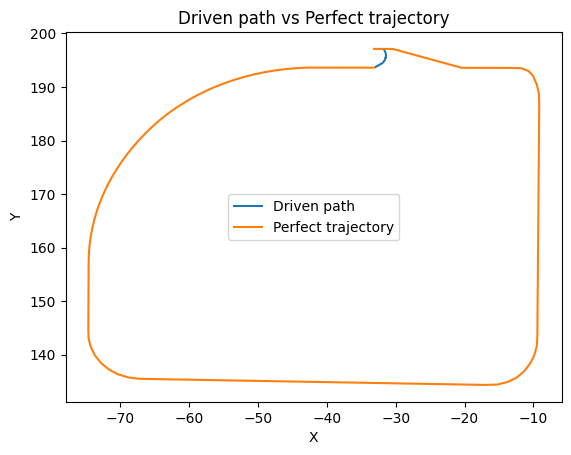

Average velocity: 0.03 m/s
Average acceleration: -0.10 m/s^2
Max acceleration: 0.00 m/s^2
Driven path length: 3.75 meters
Ideal trajectory length: 230.24 meters
DTW: 5470.856332464757
DTW: 5470.856332464757
Calculated score: 0.00
New calculated score: -2195.44
There are 10 generated scenarios
3


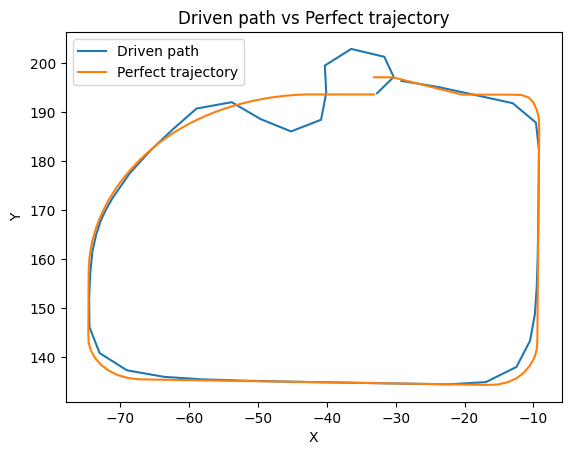

Average velocity: 0.00 m/s
Average acceleration: -0.08 m/s^2
Max acceleration: 2.84 m/s^2
Driven path length: 240.15 meters
Ideal trajectory length: 230.24 meters
DTW: 277.4927873649041
DTW: 277.4927873649041
Calculated score: 289.91
New calculated score: -187.92
There are 10 generated scenarios
2


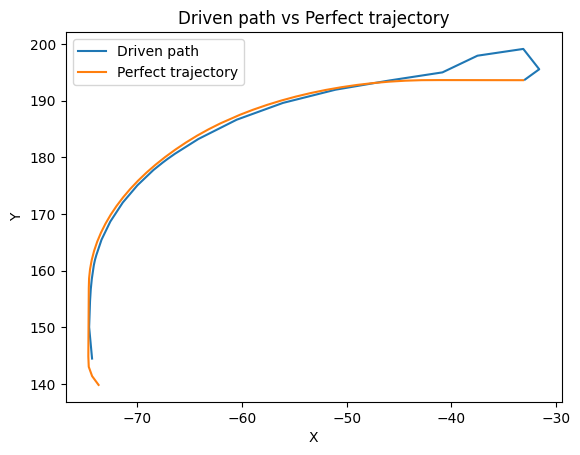

Average velocity: -0.38 m/s
Average acceleration: -0.00 m/s^2
Max acceleration: 1.41 m/s^2
Driven path length: 82.99 meters
Ideal trajectory length: 80.58 meters
DTW: 109.89242471476777
DTW: 109.89242471476777
Calculated score: 357.32
New calculated score: -44.04
There are 10 generated scenarios
0


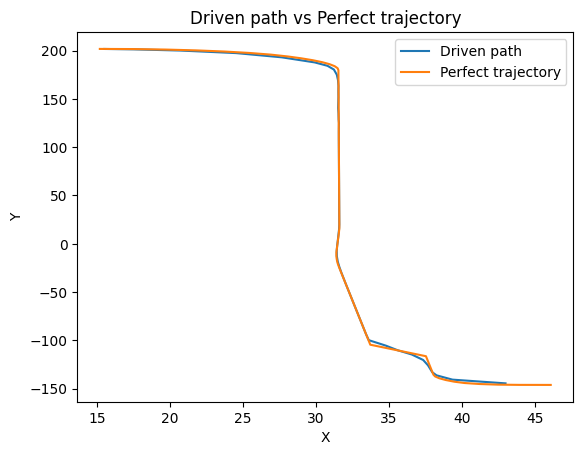

Average velocity: 0.18 m/s
Average acceleration: 0.04 m/s^2
Max acceleration: 2.60 m/s^2
Driven path length: 355.44 meters
Ideal trajectory length: 361.80 meters
DTW: 307.088761210679
DTW: 307.088761210679
Calculated score: 277.97
New calculated score: -122.43
There are 10 generated scenarios
4


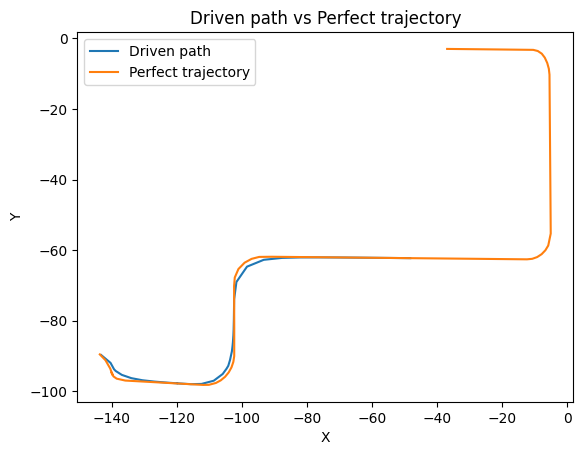

Average velocity: 1.78 m/s
Average acceleration: 0.07 m/s^2
Max acceleration: 2.03 m/s^2
Driven path length: 123.50 meters
Ideal trajectory length: 258.06 meters
DTW: 3389.0411425378343
DTW: 3389.0411425378343
Calculated score: 0.00
New calculated score: -1359.83
There are 10 generated scenarios


In [1]:
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
from dtw import *
import math
import json
import matplotlib.pyplot as plt
import numpy as np
import os

rated_objects = []
count = 0
for root, dirs, files in os.walk('user_input/NN_run/step7'):
    for file in files:
        if 'auto_scenario' in file:
        
            
            # Extract the number from the file name
            scenario_num = int(file.split('_')[-1].split('.')[0])
            print(scenario_num)
            # Open the corresponding route file
            with open(f'user_input/NN_run/step5/random_route_{scenario_num}.json', 'r') as f:
                trajectory = json.load(f)

            with open(f'user_input/NN_run/step7/auto_scenario_{scenario_num}.json') as f:
                driven_path_data = json.load(f)


            def get_trajectory_length(trajectory):
                # Extract the X and Y coordinates from each location
                x_coords = [location['X'] for location in trajectory]
                y_coords = [location['Y'] for location in trajectory]

                # Compute the Euclidean distances between consecutive points
                distances = [math.sqrt((x2 - x1)**2 + (y2 - y1)**2) for x1, y1, x2, y2 in zip(x_coords[:-1], y_coords[:-1], x_coords[1:], y_coords[1:])]

                # Return the total length of the trajectory
                return sum(distances)

            def path_length(path):
                length = 0
                for i in range(1, len(path)):
                    x1, y1 = path[i-1]
                    x2, y2 = path[i]
                    segment_length = math.sqrt((x2-x1)**2 + (y2-y1)**2)
                    length += segment_length
                return length

            

            driven_path = [(d['vehicle_location']['x'], d['vehicle_location']['y']) for d in driven_path_data]
            


            # Plot the driven path
            plt.plot(*zip(*driven_path), label='Driven path')

            # Extract the X and Y coordinates from each location
            x_coords = [location['X'] for location in trajectory]
            y_coords = [location['Y'] for location in trajectory]

          

            # Plot the route on a graph
            plt.plot(x_coords, y_coords, label='Perfect trajectory')

            plt.title('Driven path vs Perfect trajectory')
            plt.xlabel('X')
            plt.ylabel('Y')
            plt.legend()
            plt.show()

            # Initialize lists to store data
            timestamps = []
            velocities = []
            throttles = []

            # Extract values from data
            game_time = [entry['game_time'] for entry in driven_path_data]
            velocity = [entry['vehicle_velocity']['x'] for entry in driven_path_data]
            throttle = [entry['vehicle_throttle'] for entry in driven_path_data]

            # Calculate average velocity
            avg_velocity = np.mean(velocity)
            print(f'Average velocity: {avg_velocity:.2f} m/s')

            # Calculate acceleration
            dt = np.mean(np.diff(game_time))
            acceleration = np.gradient(velocity, dt)
            avg_acceleration = np.mean(acceleration)
            print(f'Average acceleration: {avg_acceleration:.2f} m/s^2')
            max_acceleration = max(acceleration)
            print(f'Max acceleration: {max_acceleration:.2f} m/s^2')

            driven_path_length = path_length(driven_path)
            print(f"Driven path length: {driven_path_length:.2f} meters")
            
            ideal_trajectory_length = get_trajectory_length(trajectory)
            print(f"Ideal trajectory length: {ideal_trajectory_length:.2f} meters")

            def new_rate_driven_path(trajectory, driven_path, avg_velocity, avg_acceleration, num_collisions):
                # Calculate the DTW distance between the trajectory and driven path
                distance, _ = fastdtw(trajectory, driven_path, dist=euclidean)

                print("DTW: "+str(distance))

                # Calculate the safety score based on distance, velocity, and acceleration
                velocity_factor = 0.01  # Weighting factor for velocity
                acceleration_factor = 0.001  # Weighting factor for acceleration
                length_factor = driven_path_length / ideal_trajectory_length  # Scaling factor based on length ratio
                scaling_factor = (1000 / avg_velocity) * (avg_acceleration / 100)  # Scaling factor based on velocity and acceleration
                safety_score = scaling_factor * length_factor - distance - velocity_factor * avg_velocity - acceleration_factor * avg_acceleration

                # Penalize for number of collisions
                safety_score -= safety_score * (0.95**num_collisions)

                return safety_score

            def rate_driven_path(trajectory, driven_path, avg_velocity, num_collisions):
                # Calculate the DTW distance between the trajectory and driven path
                distance, _ = fastdtw(trajectory, driven_path, dist=euclidean)
                
                print("DTW: "+str(distance))
                # Calculate the safety score based on DTW distance and average velocity
                safety_score = max(0, 1000 - distance - avg_velocity)
                
                # Penalize for number of collisions
                safety_score -= safety_score * (0.95**num_collisions)
            
                return safety_score

            # # # Plot velocity over time
            # plt.plot(game_time, velocity)
            # plt.xlabel('Time (s)')
            # plt.ylabel('Velocity (m/s)')
            # plt.show()

            # # Plot acceleration over time
            # plt.plot(game_time, acceleration)
            # plt.xlabel('Time (s)')
            # plt.ylabel('Acceleration (m/s^2)')
            # plt.show()

            perfect_trajectory_array = list(zip(x_coords, y_coords))
            driven_path_array = np.array(driven_path)

            calculated_score = rate_driven_path(perfect_trajectory_array, driven_path_array,avg_velocity,10)
            new_calculated_score = new_rate_driven_path(perfect_trajectory_array, driven_path_array,avg_velocity,avg_acceleration,10)
            print(f'Calculated score: {calculated_score:.2f}')
            print(f'New calculated score: {new_calculated_score:.2f}')
            # Open the file for reading
            with open('user_input/NN_run/step6/high_score_scenarios.json', 'r') as f:
                data = json.load(f)

            print(f'There are {len(data)} generated scenarios')
            
           
            # Find the object with the desired scenario_num
            for obj in data:
                if obj['scenario_num'] == scenario_num:
                    # Add the new variable
                    obj['calculate_score'] = calculated_score  # Replace 0 with your desired value
                    rated_objects.append(obj)

# Open the file for writing
with open('user_input/NN_run/step8/rated_scenarios.json', 'w') as f:
    json.dump(rated_objects, f,indent=4)

